In [1]:
# !pip install seaborn


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats
import itertools


# Import data
- all thresholds: df_both_sessions

In [3]:
df_both_sessions = pd.read_csv('tidy_both_sessions_thresholds_log.csv')

In [4]:
num_thresholds_per_subj = 18
assert df_both_sessions["prolificID"].nunique() == len(df_both_sessions) / num_thresholds_per_subj, 'Fatal: Number of thresholds per subject does not match'

print(f'\nNumber of participants with both sessions: {df_both_sessions["prolificID"].nunique()}')


Number of participants with both sessions: 169


In [5]:
# # Update meridian values for reading tasks
# df_both_sessions.loc[
#     (df_both_sessions['taskName'] == 'reading') & 
#     (df_both_sessions['meridian'].isin(['Beaver', 'Desert'])),
#     'meridian'
# ] = 'first'

# df_both_sessions.loc[
#     (df_both_sessions['taskName'] == 'reading') & 
#     (df_both_sessions['meridian'].isin(['Winter', 'Islands'])),
#     'meridian'
# ] = 'second'

# Data cleaning

## Filter participants based on the quality of individual thresholds
Exclude participants with:
- acuity and crowding: numTrialsSent < 35, questSD > 0.1
- rsvp: numTrialsSent < 24, questSD > 0.1
- ordinary reading: accuracy < 60

Outputs: prolificID of participants excluded based on each criteria. 
- {taskName}_low_trial_ids
- {taskName}_large_questSD_ids
- reading_low_accuracy_ids

In [6]:
# num_trials_required = 23  # 23 trials for short staircase
num_trials_required = 35  # 35 trials for original staircase

acuity_low_trial_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["acuity"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(acuity_low_trial_ids)}')

acuity_large_questSD_ids = (
	df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["acuity"]) & (df_both_sessions["questSD"] > 0.1),
        "prolificID"
	]
    .unique()
)
print(f'Number of participants with at least 1 threshold with questSD > 0.1: {len(acuity_large_questSD_ids)}')


Number of participants with at least 1 threshold with number of trials < 35: 16
Number of participants with at least 1 threshold with questSD > 0.1: 3


In [7]:
# num_trials_required = 23  # 23 trials for short staircase
num_trials_required = 35  # 35 trials for original staircase

crowding_low_trial_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["crowding"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(crowding_low_trial_ids)}')

crowding_large_questSD_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["crowding"]) & (df_both_sessions["questSD"] > 0.1),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with questSD > 0.1: {len(crowding_large_questSD_ids)}')


Number of participants with at least 1 threshold with number of trials < 35: 22
Number of participants with at least 1 threshold with questSD > 0.1: 28


In [8]:
# num_trials_required = 16  # 16 trials for short staircase
num_trials_required = 24  # 24 trials for original staircase

rsvp_low_trial_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["rsvp"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(rsvp_low_trial_ids)}')

rsvp_large_questSD_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["rsvp"]) & (df_both_sessions["questSD"] > 0.1),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with questSD > 0.1: {len(rsvp_large_questSD_ids)}')


Number of participants with at least 1 threshold with number of trials < 24: 0
Number of participants with at least 1 threshold with questSD > 0.1: 11


In [9]:
reading_low_accuracy_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["reading"]) & (df_both_sessions["readingCQAccuracy"] < 60),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 measurement with accuracy < 60%: {len(reading_low_accuracy_ids)}')


Number of participants with at least 1 measurement with accuracy < 60%: 63


## Compute the geometric mean of thresholds
- within the same block (one threshold per block): df_gmean_block
- across blocks for each task (one threshold per task): df_gmean_task
- within the same meridian (one threshold per meridian): df_gmean_meridian
- all data are logged so we can simply take the mean

In [10]:
# Group by participant, task, and repeat
df_gmean_block = (
    df_both_sessions.groupby(["prolificID", "taskName", "repeat"], observed=True)
					.agg(gmean_threshold_block=("threshold", lambda x: np.mean(x.dropna())))
					.reset_index()
)
df_gmean_block

,prolificID,taskName,repeat,gmean_threshold_block
0,559ad287fdf99b219a612d22,acuity,1,-0.415187
1,559ad287fdf99b219a612d22,acuity,2,-0.480609
2,559ad287fdf99b219a612d22,crowding,1,0.845687
3,559ad287fdf99b219a612d22,crowding,2,0.882659
4,559ad287fdf99b219a612d22,crowding,3,0.950354
...,...,...,...,...
1685,67fffee26ec983c07f3a2abd,crowding,4,0.140155
1686,67fffee26ec983c07f3a2abd,reading,1,2.102490
1687,67fffee26ec983c07f3a2abd,reading,2,2.279796
1688,67fffee26ec983c07f3a2abd,rsvp,1,2.543958


In [11]:
# Group by participant, task, and repeat
df_gmean_task = (
    df_both_sessions.groupby(["prolificID", "taskName"], observed=True)
					.agg(gmean_threshold_task=("threshold", lambda x: np.mean(x.dropna())))
					.reset_index()
)
df_gmean_task

,prolificID,taskName,gmean_threshold_task
0,559ad287fdf99b219a612d22,acuity,-0.447898
1,559ad287fdf99b219a612d22,crowding,0.929865
2,559ad287fdf99b219a612d22,reading,2.278744
3,559ad287fdf99b219a612d22,rsvp,2.633234
4,55d51a6b8ce09000127d4821,acuity,-0.633734
...,...,...,...
671,67e461f383bb0fc948ffd5fd,rsvp,3.175839
672,67fffee26ec983c07f3a2abd,acuity,-0.476663
673,67fffee26ec983c07f3a2abd,crowding,0.352948
674,67fffee26ec983c07f3a2abd,reading,2.191143


In [12]:
# Group by participant, task, and repeat
df_gmean_meridian = (
    df_both_sessions.groupby(["prolificID", "taskName","meridian"], observed=True)
					.agg(gmean_threshold_meridian=("threshold", lambda x: np.mean(x.dropna())))
					.reset_index()
)
df_gmean_meridian

,prolificID,taskName,meridian,gmean_threshold_meridian
0,559ad287fdf99b219a612d22,acuity,L8,-0.415579
1,559ad287fdf99b219a612d22,acuity,R8,-0.480217
2,559ad287fdf99b219a612d22,crowding,L8,1.094984
3,559ad287fdf99b219a612d22,crowding,R8,0.764746
4,559ad287fdf99b219a612d22,reading,first,2.311957
...,...,...,...,...
1178,67fffee26ec983c07f3a2abd,crowding,L8,0.504142
1179,67fffee26ec983c07f3a2abd,crowding,R8,0.201753
1180,67fffee26ec983c07f3a2abd,reading,first,2.276611
1181,67fffee26ec983c07f3a2abd,reading,second,2.105675


## Filter participants based on test-retest ratio
- log(test/retest), i.e., log(test) - log(retest), note: not the ratio of the logged thresholds; take the ratio between the numerical thresholds and then take the log.
- if test and retest are very different, then it means that the participant is unreliable and therefore should be excluded 

Outputs: prolificID of participants with large test-retest ratio
- {taskName}_bad_ratio_ids

### Functions:

In [13]:
def compute_test_retest_ratio(df, block1_colname, block2_colname):
	'''
	Compute test-retest ratio: log10(block2 / block1)
    Since the data are already log-transformed, the results would be equivalent to:
    block2 - block1
	'''
	return df[block2_colname] - df[block1_colname]

def flag_outliers_IQR(
    df,
    col_prefix="log_ratio_",
    criterion_k=1.5,
    verbose=True,
):
    """
    Add boolean outlier flags to ratio columns in a pivot table.

    - Detects columns via `col_prefix`.
    - For each ratio col: computes Q1, Q3, IQR; flags values < Q1 - k*IQR or > Q3 + k*IQR.
    - Writes a boolean flag column '<ratio_col>_is_outlier'.
    Returns a new DataFrame (does not modify input).
    """
    df = df.copy()

    # Identify ratio columns
    colNames = [c for c in df.columns if c.startswith(col_prefix)]

    for col in colNames:
        # Compute IQR bounds (NaNs ignored by quantile)
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - criterion_k * iqr
        upper = q3 + criterion_k * iqr

        mask = (df[col] < lower) | (df[col] > upper)
        out_col = f"{col}_is_outlier"
        df[out_col] = mask.fillna(False)

        if verbose:
            n = int(mask.sum())
            print(f"{col}: Q1={q1:.4f}, Q3={q3:.4f}, IQR={iqr:.4f}, "
                  f"bounds=({lower:.4f}, {upper:.4f}), outliers={n}")

    return df


def exclusion_ids_from_flags(
    df_wide: pd.DataFrame,
    task: str,
    flag_cols=None,                 # e.g., ["log_ratio_2vs1_is_outlier"] or None → auto-pick all *_is_outlier
    require="any",                  # "any" = exclude if ANY flag True; "all" = exclude only if ALL flags True
):
    """
    Return a list of prolificID to exclude for a given task, based on boolean outlier flags.
    df_wide must include columns: 'prolificID', 'taskName', and *_is_outlier booleans.
    """
    d = df_wide[df_wide["taskName"] == task]

    if flag_cols is None:
        flag_cols = [c for c in d.columns if c.endswith("_is_outlier")]

    if not flag_cols:
        return []  # nothing to check

    if require == "any":
        bad = d.groupby("prolificID")[flag_cols].any().any(axis=1)
    elif require == "all":
        bad = d.groupby("prolificID")[flag_cols].all().all(axis=1)
    else:
        raise ValueError("Invalid require value. Use 'any' or 'all'.")
    return bad[bad].index.tolist()

def filter_excluding_ids(df_wide: pd.DataFrame, *exclude_lists):
    """
    Return df_wide with rows whose prolificID is NOT in any of the exclude lists.
    Accepts multiple lists/sets of IDs.
    """
    # Merge all input lists/sets into one set
    exclude_ids = set().union(*exclude_lists)
    return df_wide[~df_wide["prolificID"].isin(exclude_ids)].copy()

def filter_including_ids(df_wide: pd.DataFrame, *include_lists):
    """
    Return df_wide with rows whose prolificID IS IN any of the exclude lists.
    Accepts multiple lists/sets of IDs.
    """
    # Merge all input lists/sets into one set
    include_ids = set().union(*include_lists)
    return df_wide[df_wide["prolificID"].isin(include_ids)].copy()


In [14]:
def plot_ratio(data_array, title, num_bins=80, min_val=-2.5, max_val=2.5, abs_bool=False): # , num_bins=20, min_val=0.08, max_val=1.11
    '''
    Input:
    - data_array: an array of test-retest ratios
    - title: [string] title and x-axis label of the figure
    '''
    
    # make the bins look the same size on a log scale
    # min_val = round(np.nanmin(data_array),2)
    # max_val = round(np.nanmax(data_array),2)
    # print(f'Min and max bin limits: {min_val}, {max_val}')
    bins = np.linspace(min_val, max_val, num_bins + 1)
    if abs_bool:
        data_array = np.abs(data_array)
        title = 'Absolute ' + title
                
    plt.figure(figsize=(8, 2)) 
    plt.hist(data_array, bins=bins, color='lightyellow', edgecolor='black')# bins=bins
    plt.title(f"{title} (n = {np.count_nonzero(~np.isnan(data_array))})", fontsize = 16)
    plt.xlabel(title, fontsize = 14)
    plt.ylabel("Frequency", fontsize = 14)
    plt.xlim(min_val, max_val)
    # plt.ylim(0,100)
    # add ticks and format them as normal floats
    # tick_positions = np.linspace(0.1, 1, num=10)  
    # plt.xticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions])

    
    plt.show()

### Compute ratios:

In [15]:
df_gmean_block_wide = (df_gmean_block
        .pivot(index=["prolificID", "taskName"],
               columns="repeat",
               values="gmean_threshold_block")
        .rename(columns={1: "block1", 2: "block2", 3: "block3", 4: "block4"})
        .reset_index())

df_gmean_block_wide

repeat,prolificID,taskName,block1,block2,block3,block4
0,559ad287fdf99b219a612d22,acuity,-0.415187,-0.480609,NaN,NaN
1,559ad287fdf99b219a612d22,crowding,0.845687,0.882659,0.950354,1.040760
2,559ad287fdf99b219a612d22,reading,2.322498,2.234990,NaN,NaN
3,559ad287fdf99b219a612d22,rsvp,2.523579,2.742889,NaN,NaN
4,55d51a6b8ce09000127d4821,acuity,-0.596659,-0.670809,NaN,NaN
...,...,...,...,...,...,...
671,67e461f383bb0fc948ffd5fd,rsvp,3.190082,3.161596,NaN,NaN
672,67fffee26ec983c07f3a2abd,acuity,-0.398057,-0.555268,NaN,NaN
673,67fffee26ec983c07f3a2abd,crowding,0.532112,0.631514,0.108010,0.140155
674,67fffee26ec983c07f3a2abd,reading,2.102490,2.279796,NaN,NaN


In [16]:
df_gmean_block_wide['log_ratio_2vs1'] = compute_test_retest_ratio(df_gmean_block_wide, 'block1', 'block2')
df_gmean_block_wide['log_ratio_3vs1'] = compute_test_retest_ratio(df_gmean_block_wide, 'block1', 'block3')
df_gmean_block_wide['log_ratio_4vs1'] = compute_test_retest_ratio(df_gmean_block_wide, 'block1', 'block4')
df_gmean_block_wide['log_ratio_3vs2'] = compute_test_retest_ratio(df_gmean_block_wide, 'block2', 'block3')
df_gmean_block_wide['log_ratio_4vs2'] = compute_test_retest_ratio(df_gmean_block_wide, 'block2', 'block4')
df_gmean_block_wide['log_ratio_4vs3'] = compute_test_retest_ratio(df_gmean_block_wide, 'block3', 'block4')

In [17]:
display(df_gmean_block_wide)

repeat,prolificID,taskName,block1,block2,block3,block4,log_ratio_2vs1,log_ratio_3vs1,log_ratio_4vs1,log_ratio_3vs2,log_ratio_4vs2,log_ratio_4vs3
0,559ad287fdf99b219a612d22,acuity,-0.415187,-0.480609,NaN,NaN,-0.065422,NaN,NaN,NaN,NaN,NaN
1,559ad287fdf99b219a612d22,crowding,0.845687,0.882659,0.950354,1.040760,0.036972,0.104667,0.195073,0.067695,0.158101,0.090406
2,559ad287fdf99b219a612d22,reading,2.322498,2.234990,NaN,NaN,-0.087507,NaN,NaN,NaN,NaN,NaN
3,559ad287fdf99b219a612d22,rsvp,2.523579,2.742889,NaN,NaN,0.219310,NaN,NaN,NaN,NaN,NaN
4,55d51a6b8ce09000127d4821,acuity,-0.596659,-0.670809,NaN,NaN,-0.074150,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
671,67e461f383bb0fc948ffd5fd,rsvp,3.190082,3.161596,NaN,NaN,-0.028486,NaN,NaN,NaN,NaN,NaN
672,67fffee26ec983c07f3a2abd,acuity,-0.398057,-0.555268,NaN,NaN,-0.157210,NaN,NaN,NaN,NaN,NaN
673,67fffee26ec983c07f3a2abd,crowding,0.532112,0.631514,0.108010,0.140155,0.099403,-0.424102,-0.391956,-0.523505,-0.491359,0.032145
674,67fffee26ec983c07f3a2abd,reading,2.102490,2.279796,NaN,NaN,0.177307,NaN,NaN,NaN,NaN,NaN


### Plot ratios before filtering

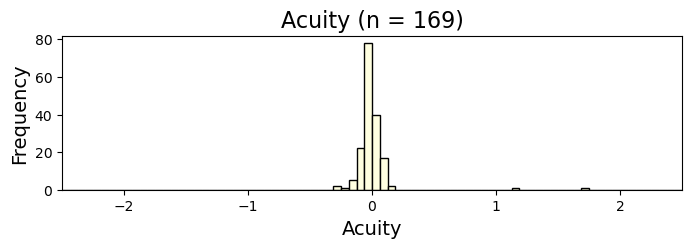

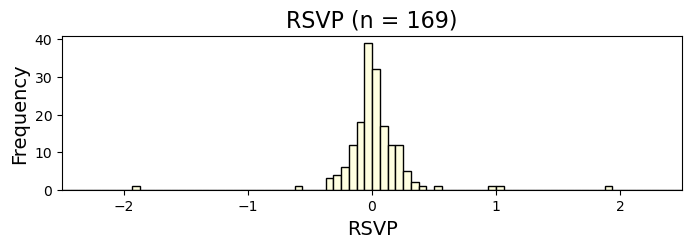

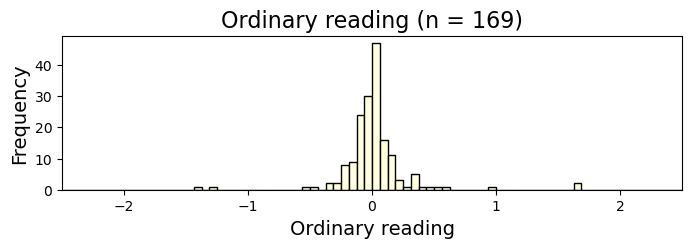

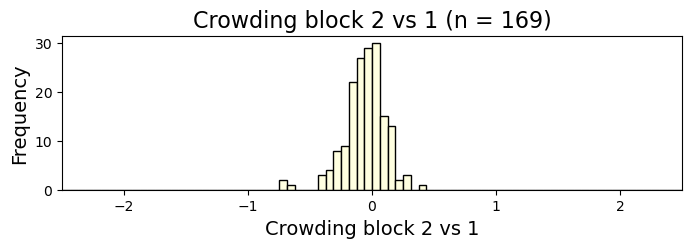

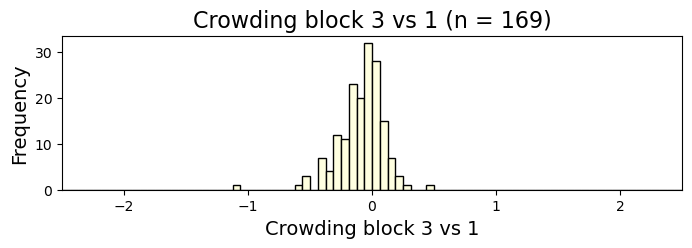

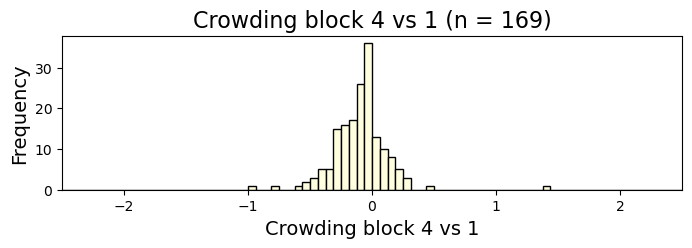

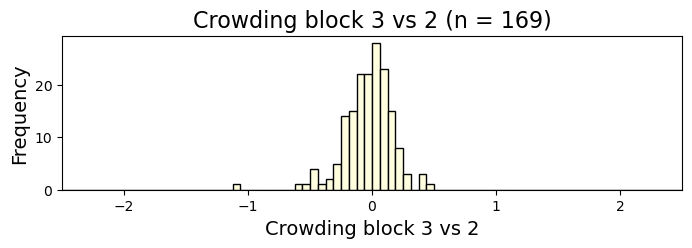

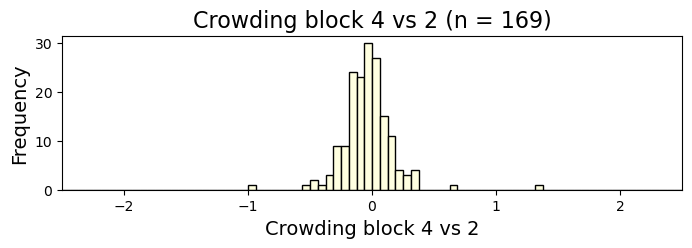

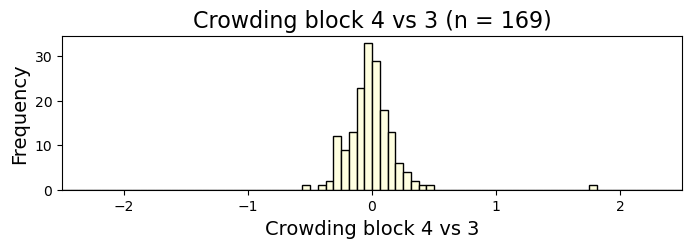

In [18]:
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "acuity"]['log_ratio_2vs1'], 'Acuity')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "rsvp"]['log_ratio_2vs1'], 'RSVP')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "reading"]['log_ratio_2vs1'], 'Ordinary reading')

plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_2vs1'], 'Crowding block 2 vs 1')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_3vs1'], 'Crowding block 3 vs 1')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_4vs1'], 'Crowding block 4 vs 1')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_3vs2'], 'Crowding block 3 vs 2')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_4vs2'], 'Crowding block 4 vs 2')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_4vs3'], 'Crowding block 4 vs 3')


### Flag outliers

In [19]:
df_gmean_block_wide_flaggedOutliers = df_gmean_block_wide.copy()
df_gmean_block_wide_flaggedOutliers = flag_outliers_IQR(df_gmean_block_wide_flaggedOutliers)

log_ratio_2vs1: Q1=-0.0792, Q3=0.0543, IQR=0.1335, bounds=(-0.2794, 0.2545), outliers=59
log_ratio_3vs1: Q1=-0.1719, Q3=0.0235, IQR=0.1954, bounds=(-0.4650, 0.3166), outliers=6
log_ratio_4vs1: Q1=-0.2062, Q3=-0.0020, IQR=0.2042, bounds=(-0.5126, 0.3043), outliers=6
log_ratio_3vs2: Q1=-0.1309, Q3=0.0897, IQR=0.2206, bounds=(-0.4618, 0.4206), outliers=7
log_ratio_4vs2: Q1=-0.1476, Q3=0.0505, IQR=0.1981, bounds=(-0.4447, 0.3477), outliers=6
log_ratio_4vs3: Q1=-0.1099, Q3=0.0722, IQR=0.1822, bounds=(-0.3832, 0.3454), outliers=5


In [20]:
display(df_gmean_block_wide_flaggedOutliers.head())

repeat,prolificID,taskName,block1,block2,block3,block4,log_ratio_2vs1,log_ratio_3vs1,log_ratio_4vs1,log_ratio_3vs2,log_ratio_4vs2,log_ratio_4vs3,log_ratio_2vs1_is_outlier,log_ratio_3vs1_is_outlier,log_ratio_4vs1_is_outlier,log_ratio_3vs2_is_outlier,log_ratio_4vs2_is_outlier,log_ratio_4vs3_is_outlier
0,559ad287fdf99b219a612d22,acuity,-0.415187,-0.480609,NaN,NaN,-0.065422,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,559ad287fdf99b219a612d22,crowding,0.845687,0.882659,0.950354,1.04076,0.036972,0.104667,0.195073,0.067695,0.158101,0.090406,False,False,False,False,False,False
2,559ad287fdf99b219a612d22,reading,2.322498,2.234990,NaN,NaN,-0.087507,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
3,559ad287fdf99b219a612d22,rsvp,2.523579,2.742889,NaN,NaN,0.219310,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
4,55d51a6b8ce09000127d4821,acuity,-0.596659,-0.670809,NaN,NaN,-0.074150,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False


### List participants filtered out by test-retest ratios

In [21]:
# exclude all participants with any outlier in any of the crowding ratios
acuity_bad_ratio_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='acuity', flag_cols=["log_ratio_2vs1_is_outlier"])
crowding_bad_ratio_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding')
rsvp_bad_ratio_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='rsvp', flag_cols=["log_ratio_2vs1_is_outlier"])
reading_bad_ratio_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='reading', flag_cols=["log_ratio_2vs1_is_outlier"])

df_all_acuity = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "acuity"]
df_filtered_acuity = filter_excluding_ids(df_all_acuity, acuity_bad_ratio_ids)

df_all_rsvp = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "rsvp"]
df_filtered_rsvp = filter_excluding_ids(df_all_rsvp, rsvp_bad_ratio_ids)

df_all_reading = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "reading"]
df_filtered_reading = filter_excluding_ids(df_all_reading, reading_bad_ratio_ids)

# Below are exclusiong ids for individual crowding ratios. Created for plotting ratios after exclusion.
crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_2vs1_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding21 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_3vs1_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding31 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_4vs1_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding41 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_3vs2_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding32 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_4vs2_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding42 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_4vs3_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding43 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)


### Plot ratios after filtering

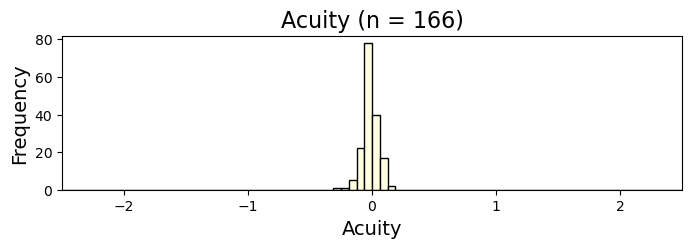

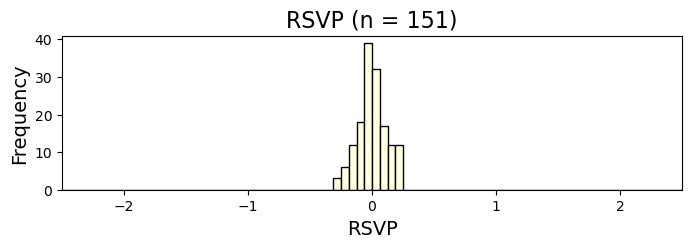

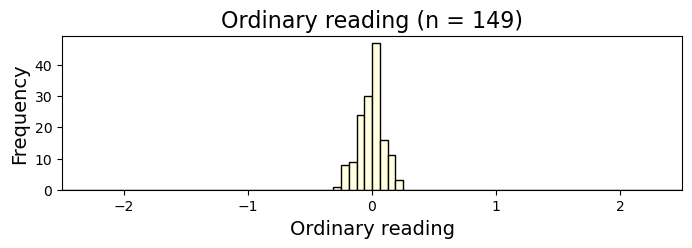

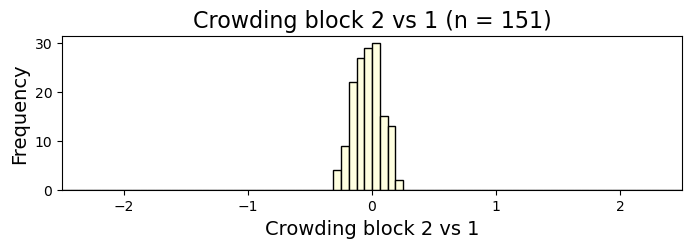

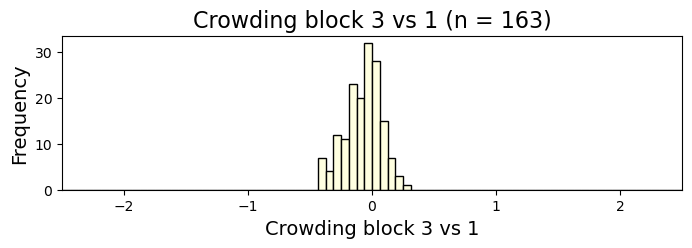

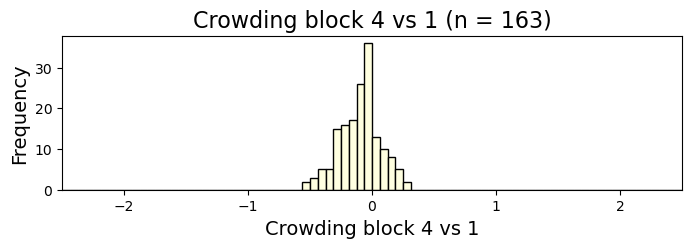

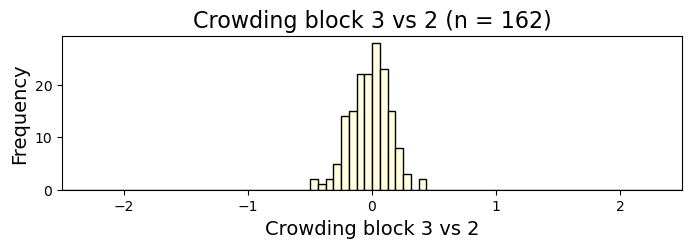

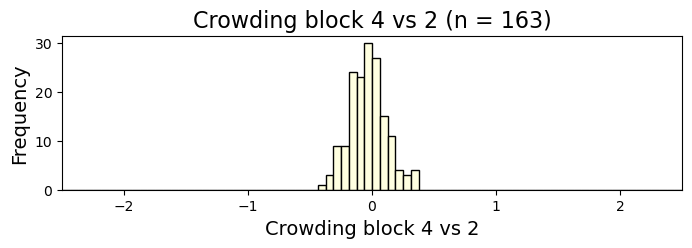

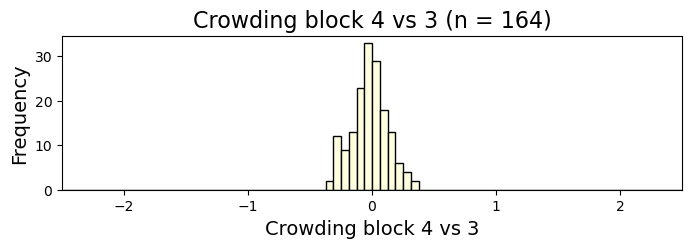

In [22]:
plot_ratio(df_filtered_acuity["log_ratio_2vs1"],title="Acuity")
plot_ratio(df_filtered_rsvp["log_ratio_2vs1"], title="RSVP")
plot_ratio(df_filtered_reading["log_ratio_2vs1"], title="Ordinary reading")

plot_ratio(df_filtered_crowding21["log_ratio_2vs1"], title="Crowding block 2 vs 1")
plot_ratio(df_filtered_crowding31["log_ratio_3vs1"], title="Crowding block 3 vs 1")
plot_ratio(df_filtered_crowding41["log_ratio_4vs1"], title="Crowding block 4 vs 1")
plot_ratio(df_filtered_crowding32["log_ratio_3vs2"], title="Crowding block 3 vs 2")
plot_ratio(df_filtered_crowding42["log_ratio_4vs2"], title="Crowding block 4 vs 2")
plot_ratio(df_filtered_crowding43["log_ratio_4vs3"], title="Crowding block 4 vs 3")

## Save the list of participants being excluded

In [23]:
# merge and deduplicate
acuity_exclude_ids = list(set(acuity_low_trial_ids) 
                          | set(acuity_large_questSD_ids) 
                          | set(acuity_bad_ratio_ids))

crowding_exclude_ids = list(set(crowding_low_trial_ids) 
                          | set(crowding_large_questSD_ids) 
                          | set(crowding_bad_ratio_ids))

rsvp_exclude_ids = list(set(rsvp_low_trial_ids) 
                          | set(rsvp_large_questSD_ids) 
                          | set(rsvp_bad_ratio_ids))

reading_exclude_ids = list(set(reading_low_accuracy_ids) 
                          | set(reading_bad_ratio_ids))

exclude_dict = {
    "acuity": acuity_exclude_ids,
    "crowding": crowding_exclude_ids,
    "reading": reading_exclude_ids,
    "rsvp": rsvp_exclude_ids
}

import json

# with open("exclude_dict.json", "w") as f:
#     json.dump(exclude_dict, f, indent=2)


In [24]:
with open("exclude_dict.json", "r") as f:
    exclude_dict = json.load(f)

# Histograms of cleaned data

### Functions:

In [25]:
def plot_threshold_array(data_array, threshold_name, hist_color='skyblue', name_sd_bool=True,
                         num_bins=50, min_val=0.08, max_val=1.11, plot_JOV_patch=False):
    '''
    Input:
    - data_array: an array of data (could be output from extract_all_thresholds)
    - threshold_name: [string] title and x-axis label of the figure
    - plot_JOV_patch: [bool] plots mean +- 1 sd from crowding data (Kurzawski, Burchell et al., 2023, JOV) 
    - assuming all data are in log10 units, but we want to plot linear data on a log scale for ease of interpretation
      so we're going to unlog them first, before plotting
    '''
    
    # make the bins look the same size on a log scale
    # min_val = round(np.nanmin(data_array),2)
    # max_val = round(np.nanmax(data_array),2)
    # print(f'Min and max bin limits: {min_val}, {max_val}')
    data_array = 10**data_array
    std_data_array = np.nanstd(data_array)


    bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins + 1)

    plt.figure(figsize=(8, 2)) 

    if plot_JOV_patch:
        lowerBound = 0.18
        upperBound = 0.41
        plt.axvspan(lowerBound, upperBound, color='lightgray', alpha=0.5) # mean +- one std
    
    if name_sd_bool:
        plt.title(f"{threshold_name} (n = {np.count_nonzero(~np.isnan(data_array))}, sd = {round(std_data_array, 2)})", fontsize = 16)
    else:
        plt.title(f"{threshold_name} (n = {np.count_nonzero(~np.isnan(data_array))})", fontsize = 16)

    plt.hist(data_array, bins=bins, color=hist_color, edgecolor='black')
    plt.xlabel(threshold_name, fontsize = 14)
    plt.ylabel("Frequency", fontsize = 14)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(0.5, 200)

    # plt.xlim()
    # plt.ylim()
    # add ticks and format them as normal floats
    # tick_positions = np.logspace(np.log10(min_val), np.log10(max_val), num=10) if plot_log_scale else np.linspace(min_val, max_val, num=10)
    # plt.xticks(tick_positions, labels=[f"{x:.2f}" for x in tick_positions])

    
    plt.show()

In [26]:
def plot_hist_task(df, taskName, y_value,
                    low_trial_ids, large_questSD_ids, bad_ratio_ids, num_bins=50, min_val=0.5, max_val=10, bouma_bool=False):
    '''
    Plot histograms for raw data, low trial data, large questSD data, bad ratio data, and cleaned data for a given task.
    '''
    df_task_raw = df[df['taskName'] == taskName]
    df_low_trial = filter_including_ids(df_task_raw, low_trial_ids)
    df_large_questSD = filter_including_ids(df_task_raw, large_questSD_ids)
    df_bad_ratio = filter_including_ids(df_task_raw, bad_ratio_ids)
    df_cleaned = filter_excluding_ids(df_task_raw, low_trial_ids, large_questSD_ids, bad_ratio_ids)
    display(df_cleaned.head())

    raw_thresholds = df_task_raw[y_value]
    low_trial_thresholds = df_low_trial[y_value]
    large_questSD_thresholds = df_large_questSD[y_value]
    bad_ratio_thresholds = df_bad_ratio[y_value]
    cleaned_thresholds = df_cleaned[y_value]

    # if bouma_bool:
    #     raw_thresholds = raw_thresholds / 8
    #     low_trial_thresholds = low_trial_thresholds / 8
    #     large_questSD_thresholds = large_questSD_thresholds / 8
    #     bad_ratio_thresholds = bad_ratio_thresholds / 8
    #     cleaned_thresholds = cleaned_thresholds / 8

    plot_threshold_array(raw_thresholds, f'{taskName} raw', num_bins=num_bins, min_val=min_val, max_val=max_val)
    plot_threshold_array(low_trial_thresholds, f'{taskName} low trials', num_bins=num_bins, min_val=min_val, max_val=max_val, hist_color='plum', name_sd_bool=False)
    plot_threshold_array(large_questSD_thresholds, f'{taskName} large questSD', num_bins=num_bins, min_val=min_val, max_val=max_val, hist_color='plum', name_sd_bool=False)
    plot_threshold_array(bad_ratio_thresholds, f'{taskName} bad test-retest ratio', num_bins=num_bins, min_val=min_val, max_val=max_val, hist_color='plum', name_sd_bool=False)
    plot_threshold_array(cleaned_thresholds, f'{taskName} cleaned', num_bins=num_bins, min_val=min_val, max_val=max_val)

### All individual thresholds:

,prolificID,conditionName,taskName,meridian,repeat,threshold,numTrialsSent,questSD,readingCQAccuracy
4,5f0788c06b220f03231666a0,acuity_R8_block1,acuity,R8,1,-0.472122,36.0,0.048382,NaN
5,5f0788c06b220f03231666a0,acuity_L8_block1,acuity,L8,1,-0.477837,35.0,0.049845,NaN
16,6778842e3f7e2e62756f7178,acuity_R8_block1,acuity,R8,1,-0.292501,35.0,0.049994,NaN
17,6778842e3f7e2e62756f7178,acuity_L8_block1,acuity,L8,1,-0.436618,36.0,0.047824,NaN
22,5e57d38b533eec1818078f0b,acuity_R8_block1,acuity,R8,1,-0.499952,36.0,0.049817,NaN


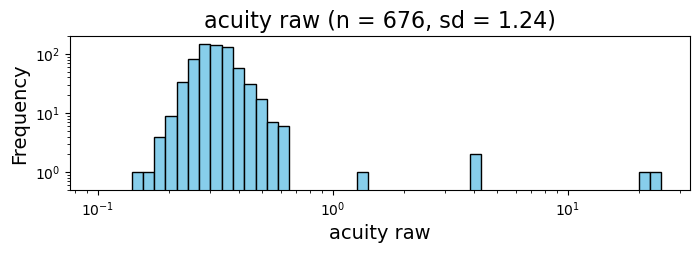

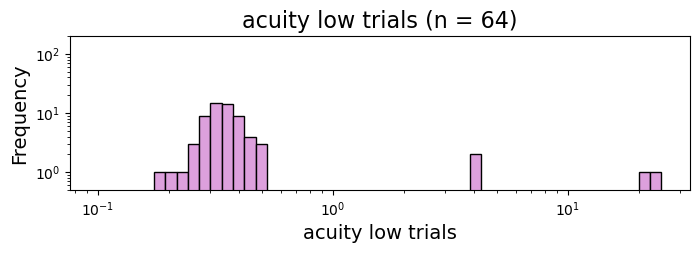

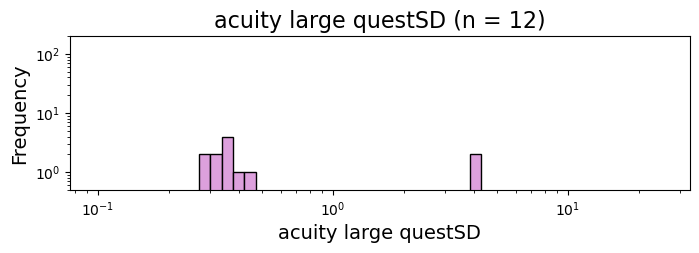

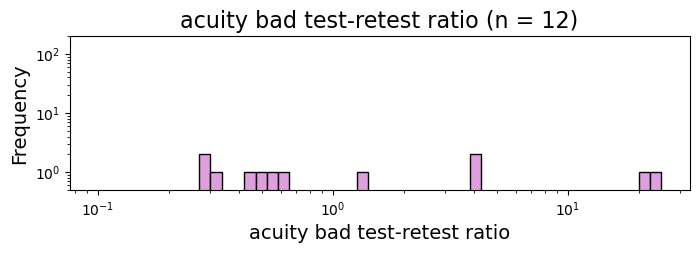

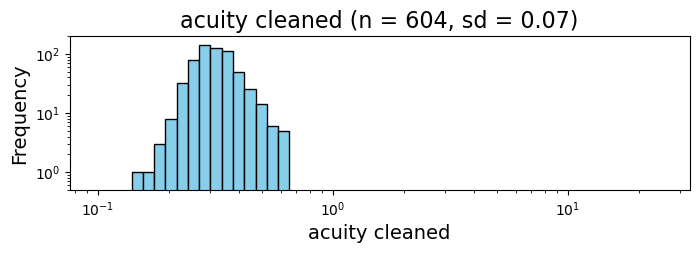

In [27]:
plot_hist_task(df_both_sessions, 'acuity', 'threshold',
                acuity_low_trial_ids, acuity_large_questSD_ids, acuity_bad_ratio_ids, 
                num_bins=50, min_val=0.1, max_val=25)

,prolificID,conditionName,taskName,meridian,repeat,threshold,numTrialsSent,questSD,readingCQAccuracy
18,5e57d38b533eec1818078f0b,crowding_R8_block1,crowding,R8,1,0.518647,36.0,0.048975,NaN
19,5e57d38b533eec1818078f0b,crowding_L8_block1,crowding,L8,1,0.504546,36.0,0.047107,NaN
20,5e57d38b533eec1818078f0b,crowding_R8_block2,crowding,R8,2,0.512413,36.0,0.047961,NaN
21,5e57d38b533eec1818078f0b,crowding_L8_block2,crowding,L8,2,0.402477,37.0,0.058266,NaN
36,63174af7d57182f9bf90c094,crowding_R8_block1,crowding,R8,1,0.629552,36.0,0.057636,NaN


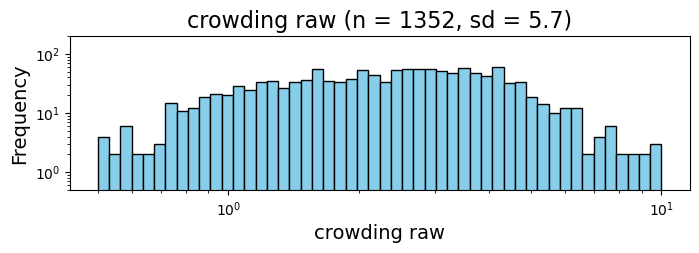

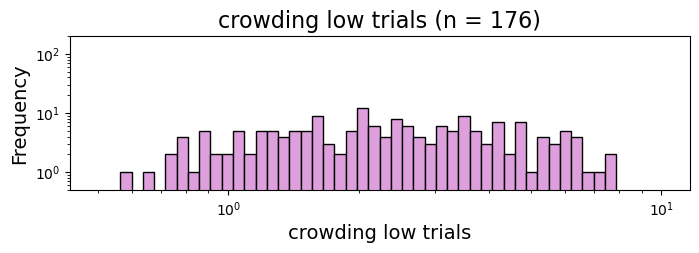

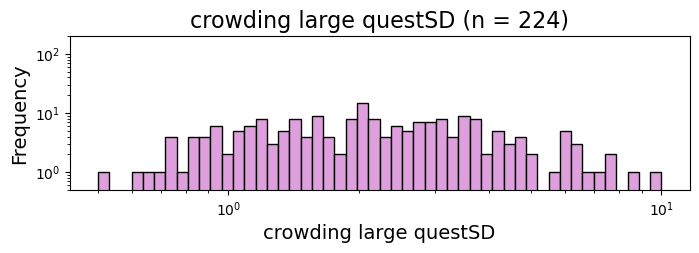

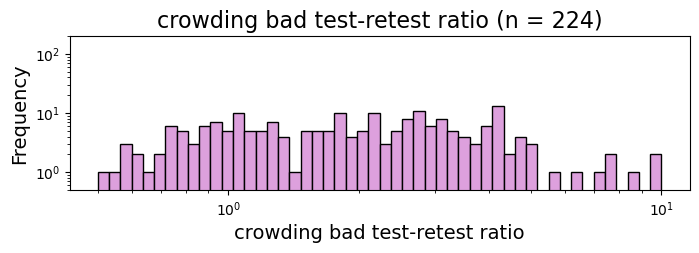

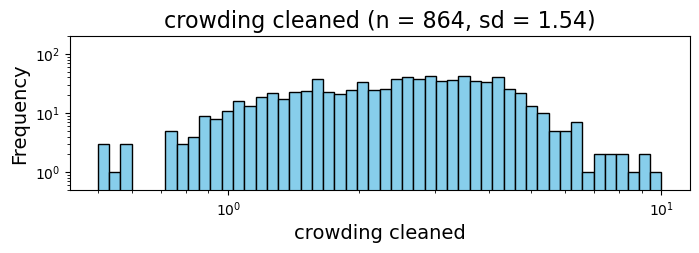

In [28]:
# crowding
plot_hist_task(df_both_sessions, 'crowding', 'threshold',
                crowding_low_trial_ids, crowding_large_questSD_ids, crowding_bad_ratio_ids)

,prolificID,conditionName,taskName,meridian,repeat,threshold,numTrialsSent,questSD,readingCQAccuracy
1014,5f0788c06b220f03231666a0,rsvp_foveal_block1,rsvp,foveal,1,3.263004,25.0,0.031329,NaN
1015,64837ba51422d817b62cc5cc,rsvp_foveal_block1,rsvp,foveal,1,3.370150,25.0,0.031303,NaN
1016,6778842e3f7e2e62756f7178,rsvp_foveal_block1,rsvp,foveal,1,3.380842,25.0,0.031597,NaN
1017,5e57d38b533eec1818078f0b,rsvp_foveal_block1,rsvp,foveal,1,3.111377,25.0,0.031854,NaN
1018,6501b789e3ddbc0a0b79b925,rsvp_foveal_block1,rsvp,foveal,1,3.331373,25.0,0.030943,NaN


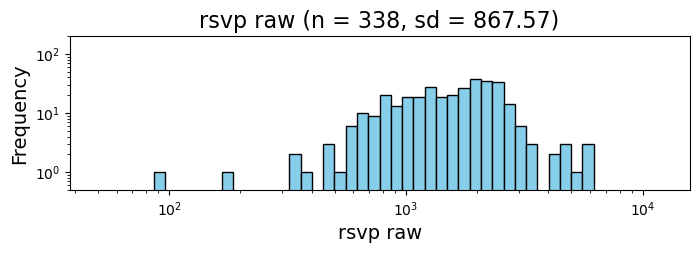

/Users/helenhu/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_76835/1513463944.py:38: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


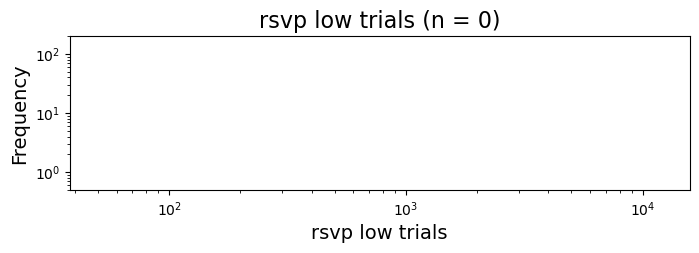

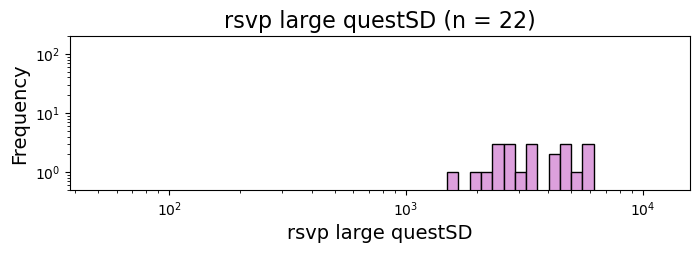

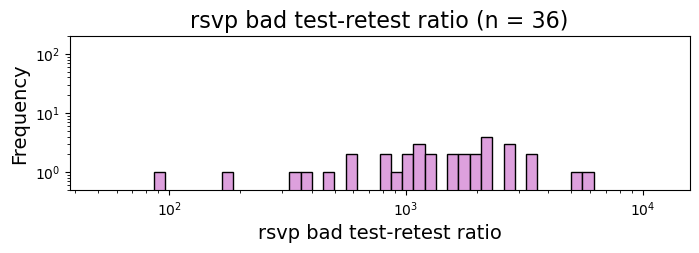

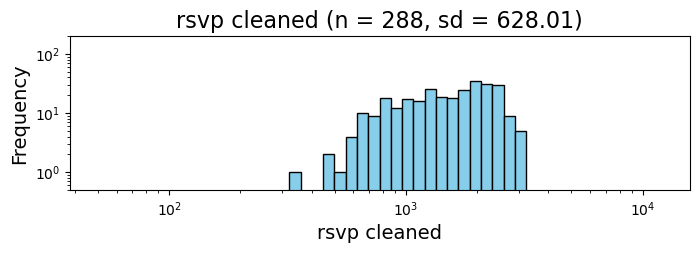

In [29]:
# rsvp
plot_hist_task(df_both_sessions, 'rsvp', 'threshold',
                rsvp_low_trial_ids, rsvp_large_questSD_ids, rsvp_bad_ratio_ids, 
                num_bins=50, min_val=50, max_val=12000)

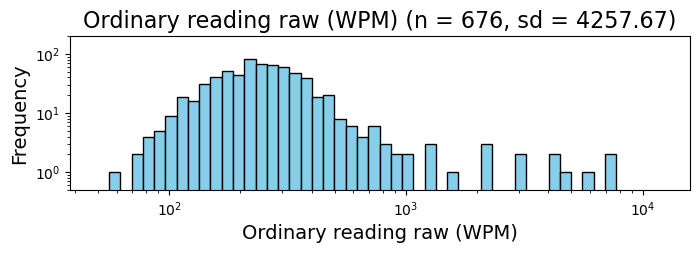

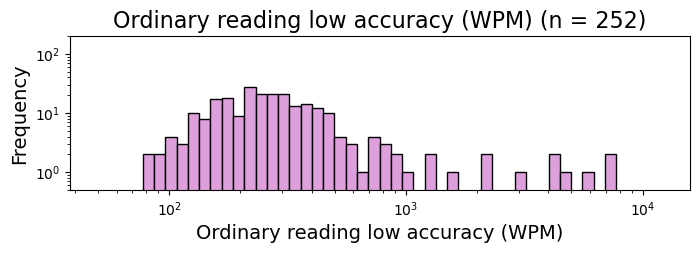

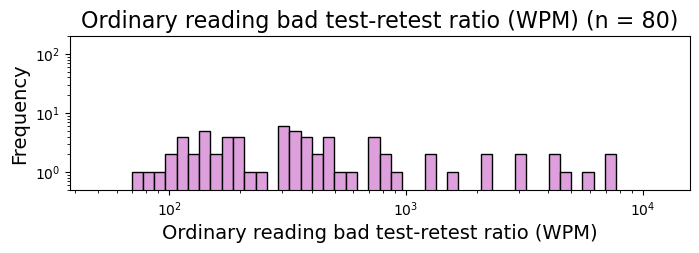

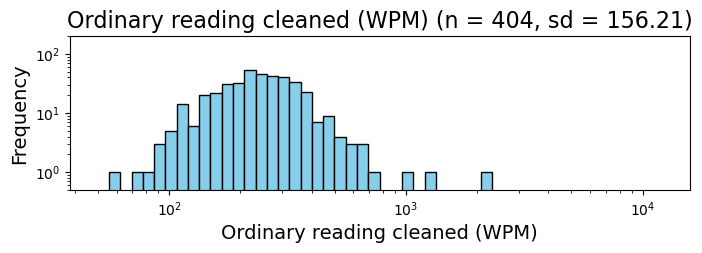

In [30]:
# ordinary reading
df_reading_allThresh_raw = df_both_sessions[df_both_sessions['taskName'] == 'reading']
df_reading_allThresh_low_trial = filter_including_ids(df_reading_allThresh_raw, reading_low_accuracy_ids)
df_reading_allThresh_bad_ratio = filter_including_ids(df_reading_allThresh_raw, reading_bad_ratio_ids)
df_reading_allThresh_cleaned = filter_excluding_ids(df_reading_allThresh_raw, reading_low_accuracy_ids, reading_bad_ratio_ids)

plot_threshold_array(df_reading_allThresh_raw['threshold'], 'Ordinary reading raw (WPM)', num_bins=50, min_val=50, max_val=12000)
plot_threshold_array(df_reading_allThresh_low_trial['threshold'], 'Ordinary reading low accuracy (WPM)', num_bins=50, min_val=50, max_val=12000, hist_color='plum', name_sd_bool=False)
plot_threshold_array(df_reading_allThresh_bad_ratio['threshold'], 'Ordinary reading bad test-retest ratio (WPM)', num_bins=50, min_val=50, max_val=12000, hist_color='plum', name_sd_bool=False)
plot_threshold_array(df_reading_allThresh_cleaned['threshold'], 'Ordinary reading cleaned (WPM)', num_bins=50, min_val=50, max_val=12000)

### Geomean for each block

,prolificID,taskName,repeat,gmean_threshold_block
0,559ad287fdf99b219a612d22,acuity,1,-0.415187
1,559ad287fdf99b219a612d22,acuity,2,-0.480609
10,55d51a6b8ce09000127d4821,acuity,1,-0.596659
11,55d51a6b8ce09000127d4821,acuity,2,-0.670809
20,5685850c333cbd000d4e042f,acuity,1,-0.494388


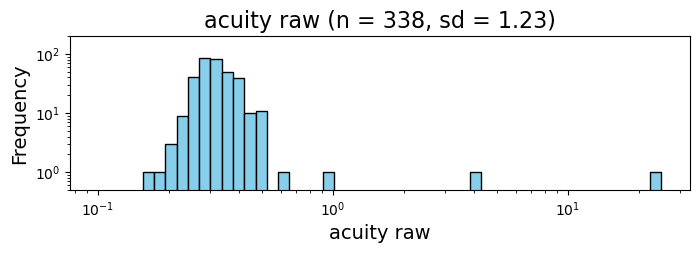

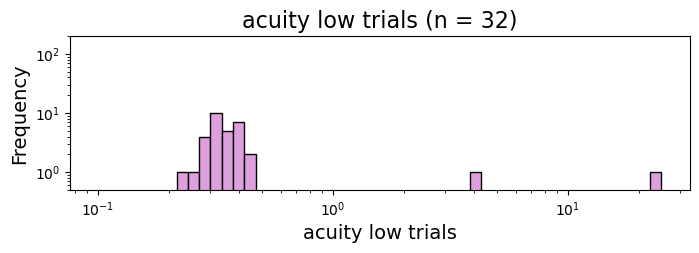

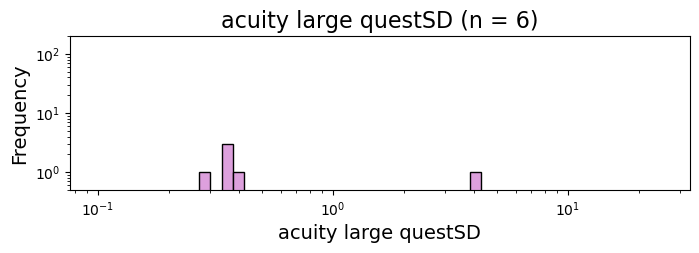

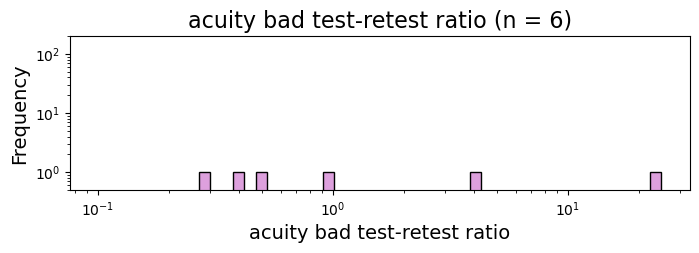

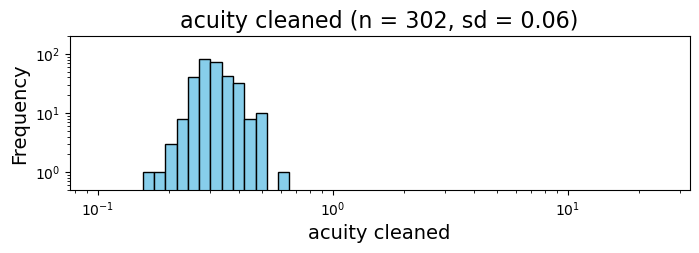

In [31]:
plot_hist_task(df_gmean_block, 'acuity', 'gmean_threshold_block',
                acuity_low_trial_ids, acuity_large_questSD_ids, acuity_bad_ratio_ids, 
                num_bins=50, min_val=0.1, max_val=25)

,prolificID,taskName,repeat,gmean_threshold_block
2,559ad287fdf99b219a612d22,crowding,1,0.845687
3,559ad287fdf99b219a612d22,crowding,2,0.882659
4,559ad287fdf99b219a612d22,crowding,3,0.950354
5,559ad287fdf99b219a612d22,crowding,4,1.040760
12,55d51a6b8ce09000127d4821,crowding,1,0.089592


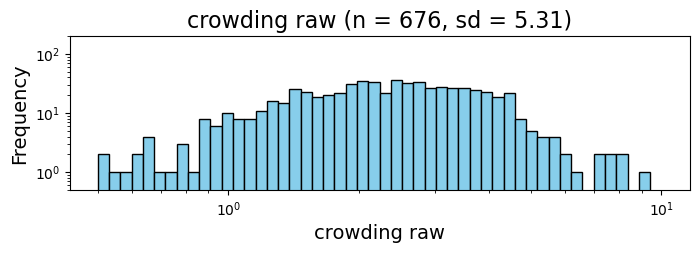

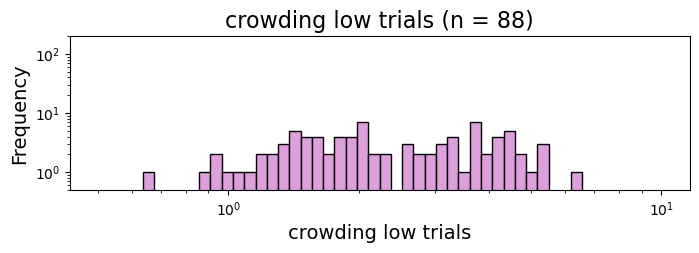

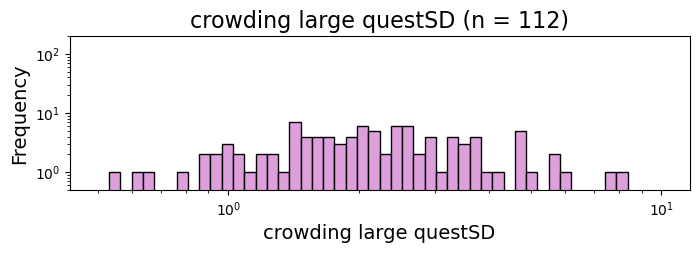

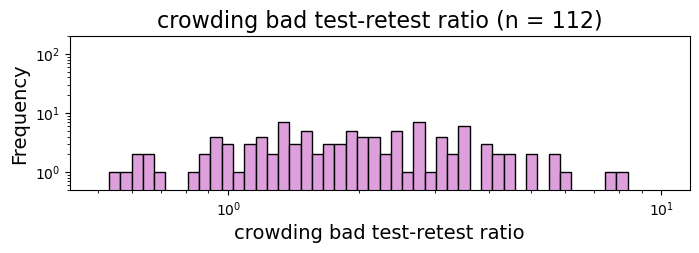

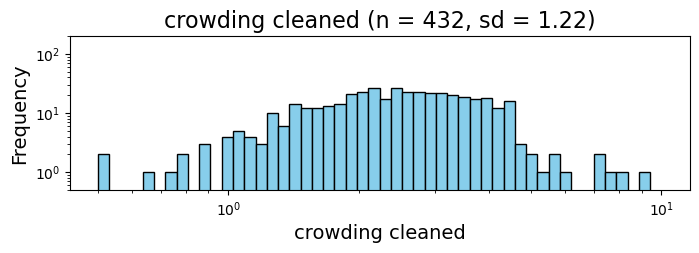

In [32]:
# crowding
plot_hist_task(df_gmean_block, 'crowding', 'gmean_threshold_block',
                crowding_low_trial_ids, crowding_large_questSD_ids, crowding_bad_ratio_ids)

,prolificID,taskName,repeat,gmean_threshold_block
8,559ad287fdf99b219a612d22,rsvp,1,2.523579
9,559ad287fdf99b219a612d22,rsvp,2,2.742889
28,5685850c333cbd000d4e042f,rsvp,1,3.252130
29,5685850c333cbd000d4e042f,rsvp,2,3.274171
38,56b78f11e77ebe000cbefe79,rsvp,1,3.038510


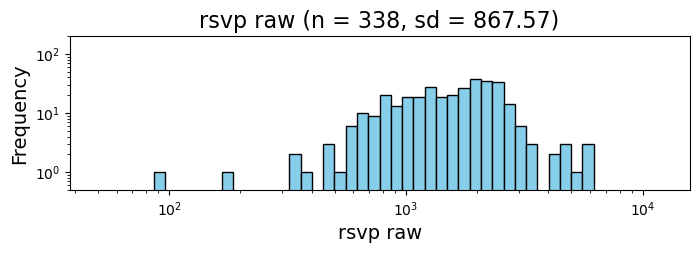

/Users/helenhu/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_76835/1513463944.py:38: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


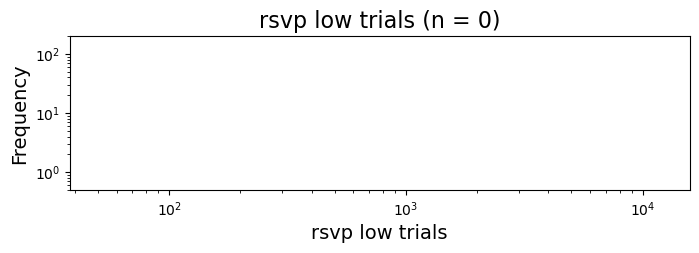

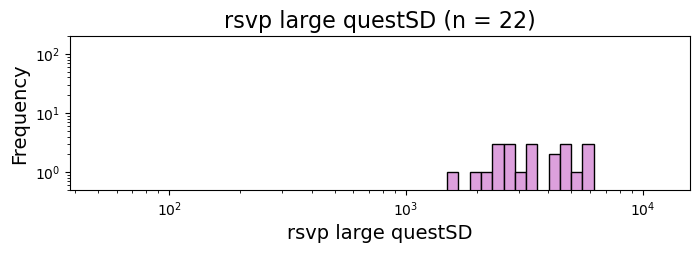

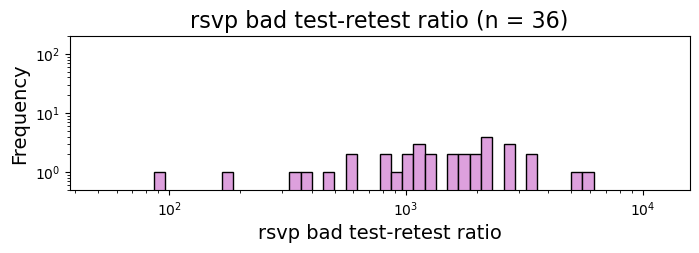

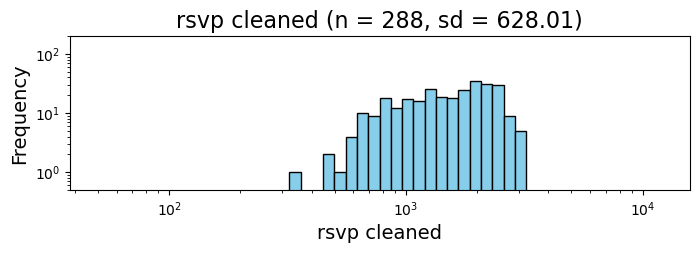

In [33]:
# rsvp
plot_hist_task(df_gmean_block, 'rsvp', 'gmean_threshold_block', 
                rsvp_low_trial_ids, rsvp_large_questSD_ids, rsvp_bad_ratio_ids, 
                num_bins=50, min_val=50, max_val=12000)

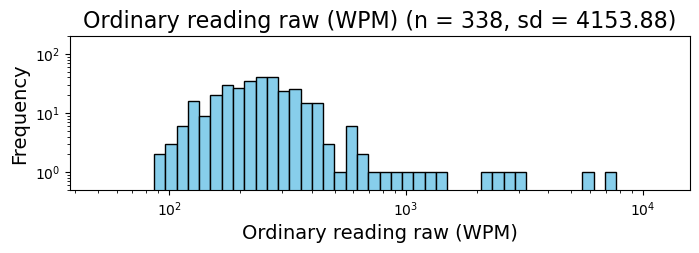

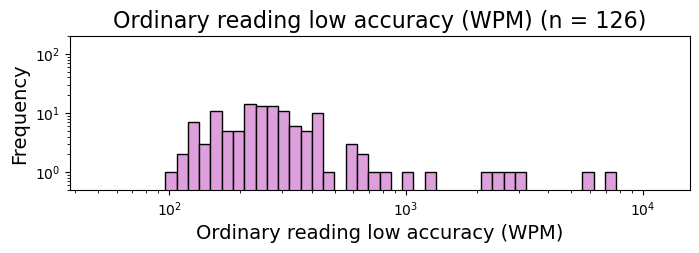

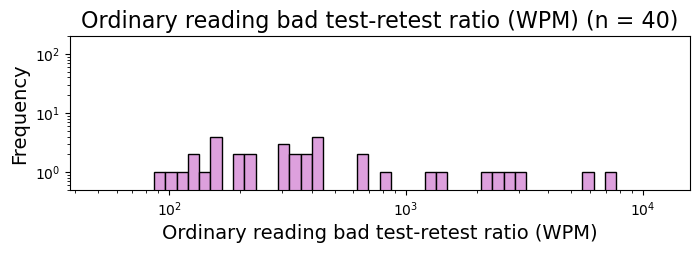

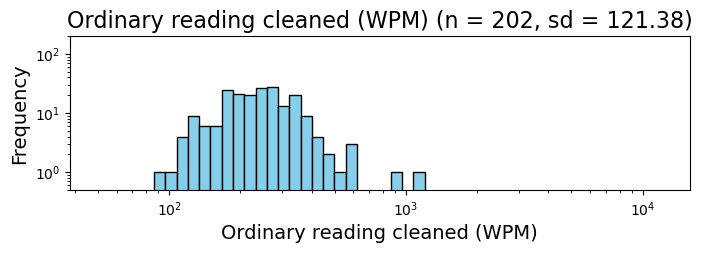

In [34]:
# ordinary reading
df_reading_gmean_block_raw = df_gmean_block[df_gmean_block['taskName'] == 'reading']
df_reading_gmean_block_low_trial = filter_including_ids(df_reading_gmean_block_raw, reading_low_accuracy_ids)
df_reading_gmean_block_bad_ratio = filter_including_ids(df_reading_gmean_block_raw, reading_bad_ratio_ids)
df_reading_gmean_block_cleaned = filter_excluding_ids(df_reading_gmean_block_raw, reading_low_accuracy_ids, reading_bad_ratio_ids)

plot_threshold_array(df_reading_gmean_block_raw['gmean_threshold_block'], 'Ordinary reading raw (WPM)', num_bins=50, min_val=50, max_val=12000)
plot_threshold_array(df_reading_gmean_block_low_trial['gmean_threshold_block'], 'Ordinary reading low accuracy (WPM)', num_bins=50, min_val=50, max_val=12000, hist_color='plum', name_sd_bool=False)
plot_threshold_array(df_reading_gmean_block_bad_ratio['gmean_threshold_block'], 'Ordinary reading bad test-retest ratio (WPM)', num_bins=50, min_val=50, max_val=12000, hist_color='plum', name_sd_bool=False)
plot_threshold_array(df_reading_gmean_block_cleaned['gmean_threshold_block'], 'Ordinary reading cleaned (WPM)', num_bins=50, min_val=50, max_val=12000)

### Geomean for each task:

,prolificID,taskName,gmean_threshold_task
0,559ad287fdf99b219a612d22,acuity,-0.447898
4,55d51a6b8ce09000127d4821,acuity,-0.633734
8,5685850c333cbd000d4e042f,acuity,-0.517487
12,56b78f11e77ebe000cbefe79,acuity,-0.451985
16,57334d427d01ed00098e8e69,acuity,-0.539654


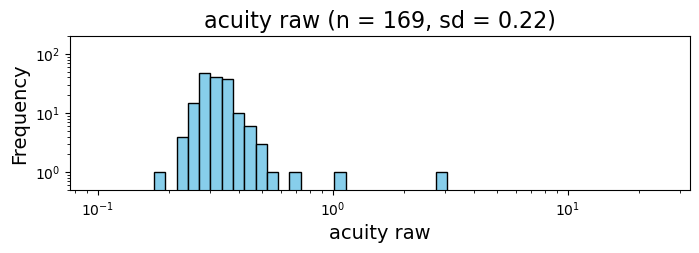

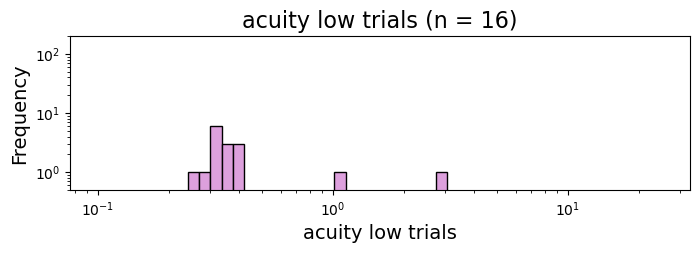

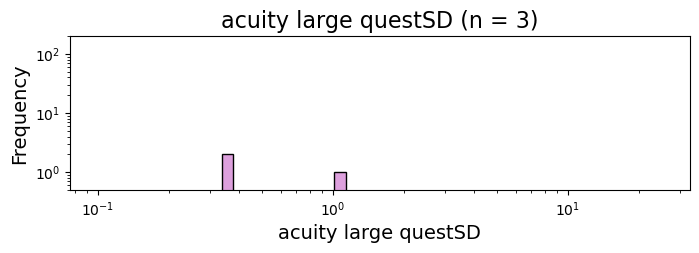

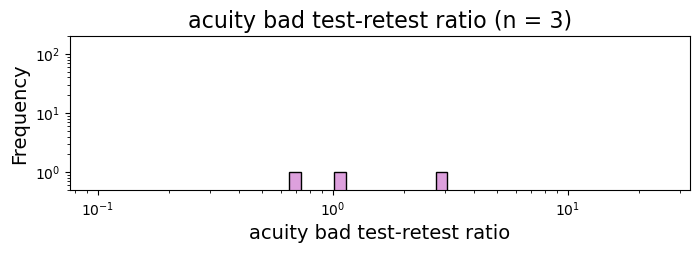

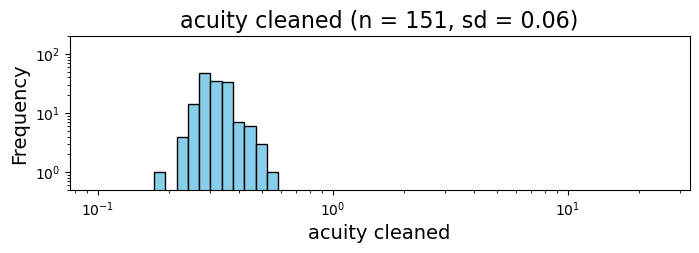

In [35]:
plot_hist_task(df_gmean_task, 'acuity', 'gmean_threshold_task',
                acuity_low_trial_ids, acuity_large_questSD_ids, acuity_bad_ratio_ids, 
                num_bins=50, min_val=0.1, max_val=25)

,prolificID,taskName,gmean_threshold_task
1,559ad287fdf99b219a612d22,crowding,0.929865
5,55d51a6b8ce09000127d4821,crowding,0.036757
17,57334d427d01ed00098e8e69,crowding,0.225920
21,581bd344930a280001062c90,crowding,0.334971
33,588ab33542c8e900019d02ae,crowding,0.077324


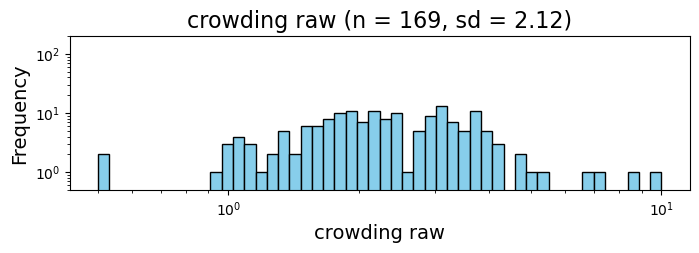

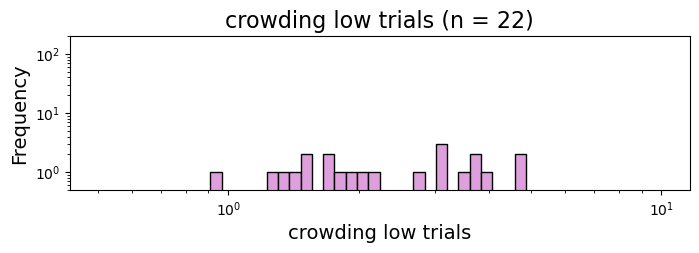

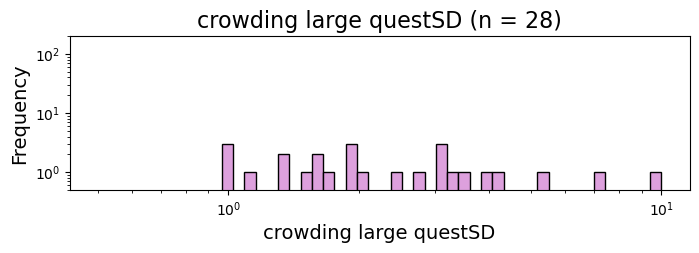

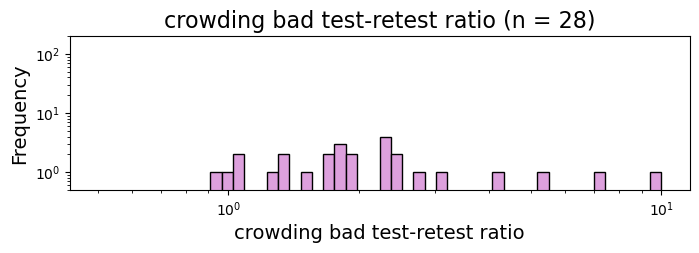

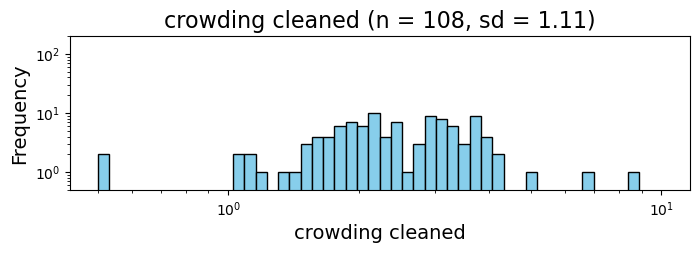

In [36]:
# crowding
plot_hist_task(df_gmean_task, 'crowding', 'gmean_threshold_task',
                crowding_low_trial_ids, crowding_large_questSD_ids, crowding_bad_ratio_ids)

,prolificID,taskName,gmean_threshold_task
3,559ad287fdf99b219a612d22,rsvp,2.633234
11,5685850c333cbd000d4e042f,rsvp,3.263151
15,56b78f11e77ebe000cbefe79,rsvp,3.144948
19,57334d427d01ed00098e8e69,rsvp,3.147468
23,581bd344930a280001062c90,rsvp,3.217009


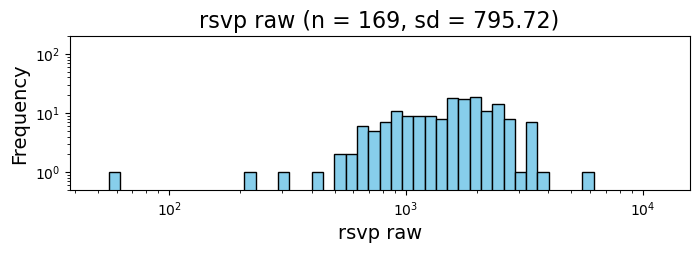

/Users/helenhu/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_76835/1513463944.py:38: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


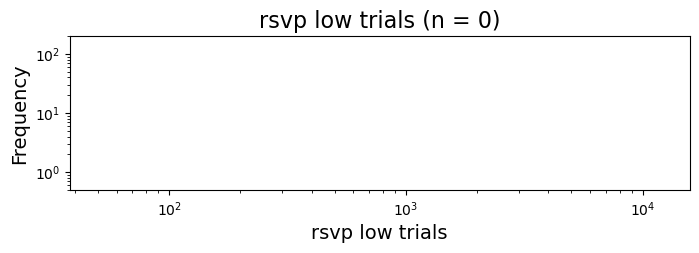

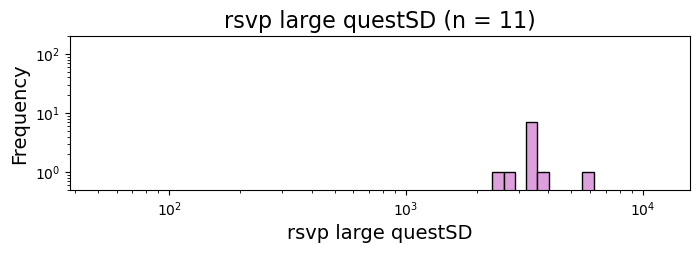

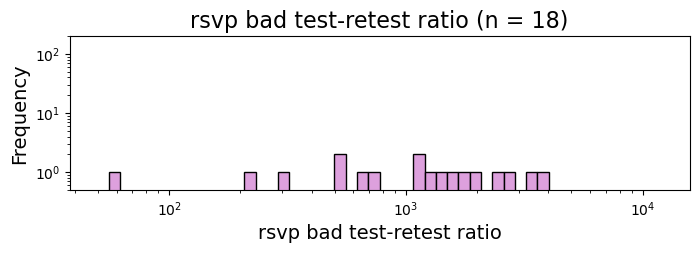

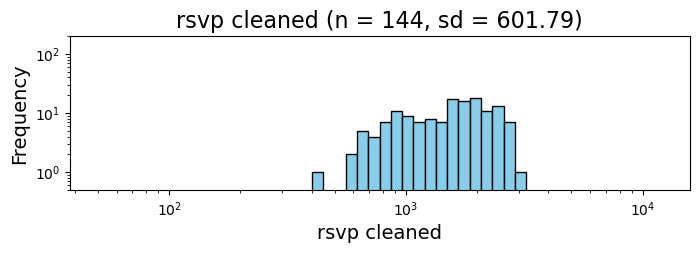

In [37]:
# rsvp
plot_hist_task(df_gmean_task, 'rsvp', 'gmean_threshold_task', 
                rsvp_low_trial_ids, rsvp_large_questSD_ids, rsvp_bad_ratio_ids, 
                num_bins=50, min_val=50, max_val=12000)

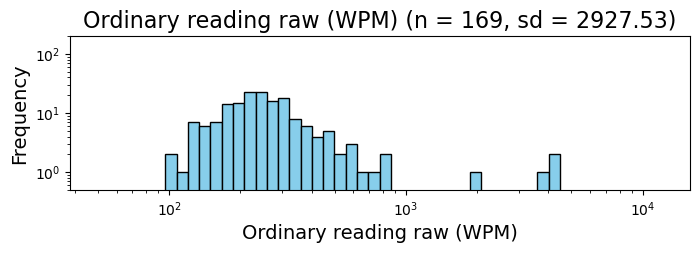

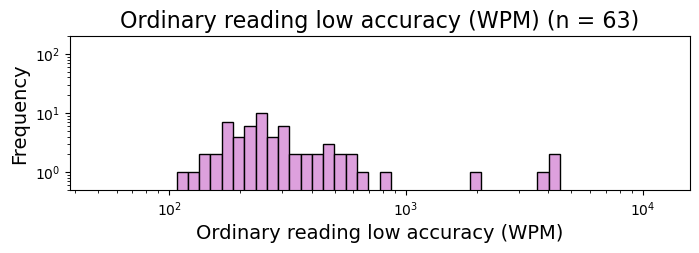

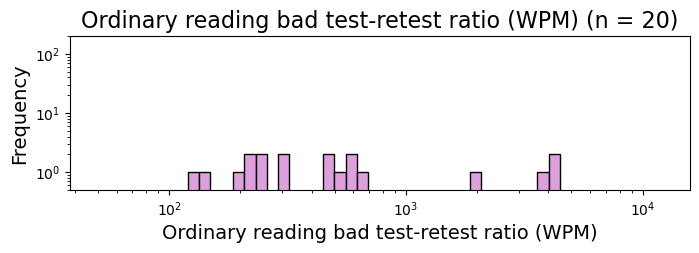

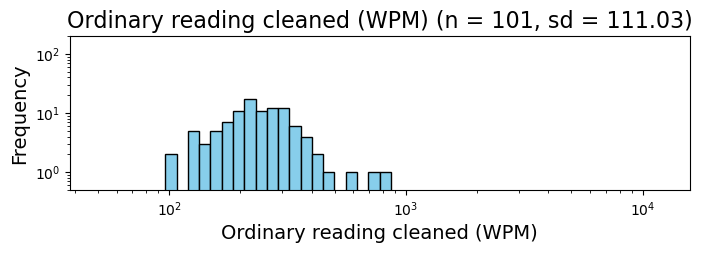

In [38]:
# ordinary reading
df_reading_gmean_task_raw = df_gmean_task[df_gmean_task['taskName'] == 'reading']
df_reading_gmean_task_low_trial = filter_including_ids(df_reading_gmean_task_raw, reading_low_accuracy_ids)
df_reading_gmean_task_bad_ratio = filter_including_ids(df_reading_gmean_task_raw, reading_bad_ratio_ids)
df_reading_gmean_task_cleaned = filter_excluding_ids(df_reading_gmean_task_raw, reading_low_accuracy_ids, reading_bad_ratio_ids)

plot_threshold_array(df_reading_gmean_task_raw['gmean_threshold_task'], 'Ordinary reading raw (WPM)', num_bins=50, min_val=50, max_val=12000)
plot_threshold_array(df_reading_gmean_task_low_trial['gmean_threshold_task'], 'Ordinary reading low accuracy (WPM)', num_bins=50, min_val=50, max_val=12000, hist_color='plum', name_sd_bool=False)
plot_threshold_array(df_reading_gmean_task_bad_ratio['gmean_threshold_task'], 'Ordinary reading bad test-retest ratio (WPM)', num_bins=50, min_val=50, max_val=12000, hist_color='plum', name_sd_bool=False)
plot_threshold_array(df_reading_gmean_task_cleaned['gmean_threshold_task'], 'Ordinary reading cleaned (WPM)', num_bins=50, min_val=50, max_val=12000)

# Analysis
- note that everything in is now logged

### Functions

In [39]:
def filter_task_df(df, taskName, 
                    low_trial_ids, large_questSD_ids, bad_ratio_ids):
    '''
    filter data by number of trials, questSD, and test-retest ratio for a given task.
    '''
    df_task_raw = df[df['taskName'] == taskName]
    df_cleaned = filter_excluding_ids(df_task_raw, low_trial_ids, large_questSD_ids, bad_ratio_ids)

    return df_cleaned

In [40]:
from matplotlib.ticker import FixedLocator, FixedFormatter, LogLocator, NullFormatter

def plot_scatter_with_correlation(var_x, var_y, var_x_name, var_y_name, plotXequalsY_bool=False, equal_axes_bool=True,
								  myticks = np.linspace(1,9,5)):
	"""
	Plots a scatter plot of two variables from a DataFrame and computes Pearson's r.

	Parameters:
		var_x (list): first variable extracted from a df
		var_y (list): second variable extracted from a df
	"""
	var_x = np.array(var_x)
	var_y = np.array(var_y)

	# print out minimum and maximum values of the variables
	min_x = var_x.min()
	min_y = var_y.min()
	max_x = var_x.max()
	max_y = var_y.max()
	print(f'Min and max values: min_x: {min_x}, max_x: {max_x}, min_y: {min_y}, max_y: {max_y}')

	# Compute Pearson correlation
	valid = (~np.isnan(var_x)) & (~np.isnan(var_y))
	r, p_value = stats.pearsonr(var_x[valid], var_y[valid])

	# Determine axis limits (same for both axes)
	min_val = min(var_x.min(), var_y.min())
	min_val = min_val - abs(min_val) * 0.01
	max_val = max(var_x.max(), var_y.max())
	max_val = max_val + abs(max_val) * 0.01


	# Create the scatter plot
	plt.figure(figsize=(4, 4))  
	sns.scatterplot(x=10**var_x, y=10**var_y, s=50, alpha=0.6)

			
	# Set limits for both axes to be the same
	if equal_axes_bool:
		plt.gca().set_aspect('equal', adjustable='box')
		plt.axis('equal')


	else:
		plt.gca().set_aspect('auto', adjustable='box')  


	# Add title with Pearson's r value
	plt.title(f"measured r = {r:.2f}", fontsize=16)

	# Add labels
	plt.xlabel(var_x_name, fontsize=14)
	plt.ylabel(var_y_name, fontsize=14)
	plt.xticks(fontsize=10)  
	plt.yticks(fontsize=10) 
	plt.xscale("log")
	plt.yscale("log")
	# plot x = y
	if plotXequalsY_bool:
		plt.plot([10**min_val, 10**max_val], [10**min_val, 10**max_val], color="black", linestyle="--", linewidth=1)
		

	# Create identical ticks, rounded to nearest whole number
	ticks = np.round(myticks).astype(int)
	ax = plt.gca()
        
	# force major ticks & labels exactly where you want them
	ax.xaxis.set_major_locator(FixedLocator(ticks))
	ax.xaxis.set_major_formatter(FixedFormatter([str(t) for t in ticks]))

	ax.yaxis.set_major_locator(FixedLocator(ticks))
	ax.yaxis.set_major_formatter(FixedFormatter([str(t) for t in ticks]))

	# # (optional) add minor log ticks but hide their labels
	# remove minor ticks entirely
	ax.xaxis.set_minor_locator(FixedLocator([]))
	ax.yaxis.set_minor_locator(FixedLocator([]))
	plt.xticks(rotation=45, ha="right")
	# Show plot
	plt.show()


In [41]:
def make_task_wide(block_df, task_df, task_name):
    """
    block_df: columns ['prolificID','taskName','repeat','gmean_threshold_block']
    task_df : columns ['prolificID','taskName','repeat','gmean_threshold_task']
    returns: wide df with columns like ['prolificID', f'{task}_block1', ..., f'{task}_grandMean']
    """

    # 1) pivot blocks → one column per repeat
    wide_blocks = (block_df
                   .pivot(index="prolificID", columns="repeat", values="gmean_threshold_block")
                   .sort_index(axis=1))  # ensure block1, block2, ...

    # rename e.g. 1→'acuity_block1'
    wide_blocks.columns = [f"{task_name}_block{int(c)}" for c in wide_blocks.columns]

    # 2) grand mean per participant (use task_df; if multiple rows, average them)
    grand = (task_df
             .groupby("prolificID", as_index=True)["gmean_threshold_task"]
             .mean()
             .rename(f"{task_name}_grandMean")
             .to_frame())

    # combine and return
    out = wide_blocks.join(grand, how="outer").reset_index()
    return out


def build_big_df(task_to_dfs):
    """
    task_to_dfs: dict like {
        'acuity':   (acuity_gmean_block_cleaned_df,   acuity_gmean_task_cleaned_df),
        'crowding': (crowding_gmean_block_cleaned_df, crowding_gmean_task_cleaned_df),
        'rsvp':     (rsvp_gmean_block_cleaned_df,     rsvp_gmean_task_cleaned_df),
        'reading':  (reading_gmean_block_cleaned_df,  reading_gmean_task_cleaned_df),
    }
    returns one big df with prolificID rows and all task columns.
    """
    pieces = []
    for task, (block_df, task_df) in task_to_dfs.items():
        w = make_task_wide(block_df, task_df, task)
        pieces.append(w.set_index("prolificID"))

    big = pd.concat(pieces, axis=1)  # outer join on prolificID
    big = big.reset_index()
    return big

# Columns look like:
# ['prolificID', 'acuity_block1','acuity_block2',...,'acuity_grandMean',
#  'crowding_block1',...,'crowding_grandMean', 'rsvp_block1',...,'reading_grandMean']



### Filter data

In [42]:
acuity_indThresh_cleaned_df = filter_task_df(df_both_sessions, 'acuity', acuity_low_trial_ids, acuity_large_questSD_ids, acuity_bad_ratio_ids)
crowding_indThresh_cleaned_df = filter_task_df(df_both_sessions, 'crowding', crowding_low_trial_ids, crowding_large_questSD_ids, crowding_bad_ratio_ids)
rsvp_indThresh_cleaned_df = filter_task_df(df_both_sessions, 'rsvp', rsvp_low_trial_ids, rsvp_large_questSD_ids, rsvp_bad_ratio_ids)
reading_indThresh_cleaned_df = filter_task_df(df_both_sessions, 'reading', reading_low_accuracy_ids, [], reading_bad_ratio_ids) 


In [43]:
acuity_gmean_meridian_cleaned_df = filter_task_df(df_gmean_meridian, 'acuity', acuity_low_trial_ids, acuity_large_questSD_ids, acuity_bad_ratio_ids)
crowding_gmean_meridian_cleaned_df = filter_task_df(df_gmean_meridian, 'crowding', crowding_low_trial_ids, crowding_large_questSD_ids, crowding_bad_ratio_ids)
rsvp_gmean_meridian_cleaned_df = filter_task_df(df_gmean_meridian, 'rsvp', rsvp_low_trial_ids, rsvp_large_questSD_ids, rsvp_bad_ratio_ids)
reading_gmean_meridian_cleaned_df = filter_task_df(df_gmean_meridian, 'reading', reading_low_accuracy_ids, [], reading_bad_ratio_ids)

In [44]:
acuity_gmean_block_cleaned_df = filter_task_df(df_gmean_block, 'acuity', acuity_low_trial_ids, acuity_large_questSD_ids, acuity_bad_ratio_ids)
crowding_gmean_block_cleaned_df = filter_task_df(df_gmean_block, 'crowding', crowding_low_trial_ids, crowding_large_questSD_ids, crowding_bad_ratio_ids)
rsvp_gmean_block_cleaned_df = filter_task_df(df_gmean_block, 'rsvp', rsvp_low_trial_ids, rsvp_large_questSD_ids, rsvp_bad_ratio_ids)
reading_gmean_block_cleaned_df = filter_task_df(df_gmean_block, 'reading', reading_low_accuracy_ids, [], reading_bad_ratio_ids) 

acuity_gmean_task_cleaned_df = filter_task_df(df_gmean_task, 'acuity', acuity_low_trial_ids, acuity_large_questSD_ids, acuity_bad_ratio_ids)
crowding_gmean_task_cleaned_df = filter_task_df(df_gmean_task, 'crowding', crowding_low_trial_ids, crowding_large_questSD_ids, crowding_bad_ratio_ids)
rsvp_gmean_task_cleaned_df = filter_task_df(df_gmean_task, 'rsvp', rsvp_low_trial_ids, rsvp_large_questSD_ids, rsvp_bad_ratio_ids)
reading_gmean_task_cleaned_df = filter_task_df(df_gmean_task, 'reading', reading_low_accuracy_ids, [], reading_bad_ratio_ids) 

In [45]:
# # sanity check for RSVP: if we don't exclude by test-retest ratio, we get really low r(test, retest)
# rsvp_tt = filter_task_df(df_gmean_block, 'rsvp', rsvp_low_trial_ids, [], [])
# rsvp_wide = rsvp_tt.pivot_table(
#     index=['prolificID'], columns='repeat', values='gmean_threshold_block'
# )
# rsvp_wide = rsvp_wide.rename(columns=lambda x: f"repeat{x}" if isinstance(x, (int, float)) else x)

# rsvp_r, p = stats.pearsonr(rsvp_wide['repeat1'], rsvp_wide['repeat2'])
# print(rsvp_r)

### Create and save pivot table for correlation analysis

In [46]:
task_to_dfs = {
    "acuity":   (acuity_gmean_block_cleaned_df,   acuity_gmean_task_cleaned_df),
    "crowding": (crowding_gmean_block_cleaned_df, crowding_gmean_task_cleaned_df),
    "rsvp":     (rsvp_gmean_block_cleaned_df,     rsvp_gmean_task_cleaned_df),
    "reading":  (reading_gmean_block_cleaned_df,  reading_gmean_task_cleaned_df),
}

big_df = build_big_df(task_to_dfs)

display(big_df.head())

,prolificID,acuity_block1,acuity_block2,acuity_grandMean,crowding_block1,crowding_block2,crowding_block3,crowding_block4,crowding_grandMean,rsvp_block1,rsvp_block2,rsvp_grandMean,reading_block1,reading_block2,reading_grandMean
0,559ad287fdf99b219a612d22,-0.415187,-0.480609,-0.447898,0.845687,0.882659,0.950354,1.040760,0.929865,2.523579,2.742889,2.633234,2.322498,2.234990,2.278744
1,55d51a6b8ce09000127d4821,-0.596659,-0.670809,-0.633734,0.089592,0.041552,0.119450,-0.103568,0.036757,NaN,NaN,NaN,2.398362,2.281513,2.339937
2,5685850c333cbd000d4e042f,-0.494388,-0.540586,-0.517487,NaN,NaN,NaN,NaN,NaN,3.252130,3.274171,3.263151,2.344673,2.411041,2.377857
3,56b78f11e77ebe000cbefe79,-0.463865,-0.440105,-0.451985,NaN,NaN,NaN,NaN,NaN,3.038510,3.251385,3.144948,2.538969,2.422927,2.480948
4,57334d427d01ed00098e8e69,-0.526725,-0.552582,-0.539654,0.365720,0.148872,0.053535,0.335556,0.225920,3.198827,3.096109,3.147468,2.393182,2.268736,2.330959


In [47]:
# big_df.to_csv('tidy_corr_data_short_staircase_log.csv', index=False)

### Create pivot table pt 2: include R and L thresholds, separately

In [48]:
all_tasks_indThresh_cleaned_df = pd.concat([
    acuity_indThresh_cleaned_df,
    crowding_indThresh_cleaned_df,
    rsvp_indThresh_cleaned_df,
    reading_indThresh_cleaned_df
], ignore_index=True)

In [49]:
all_tasks_indThresh_cleaned_wide = all_tasks_indThresh_cleaned_df.pivot(index="prolificID", columns=["conditionName"], values="threshold")

In [50]:
display(all_tasks_indThresh_cleaned_wide.head())

conditionName,acuity_L8_block1,acuity_L8_block2,acuity_R8_block1,acuity_R8_block2,crowding_L8_block1,crowding_L8_block2,crowding_L8_block3,crowding_L8_block4,crowding_R8_block1,crowding_R8_block2,crowding_R8_block3,crowding_R8_block4,reading_Beaver_block1,reading_Desert_block1,reading_Islands_block2,reading_Winter_block2,rsvp_foveal_block1,rsvp_foveal_block2
prolificID,,,,,,,,,,,,,,,,,,
559ad287fdf99b219a612d22,-0.375856,-0.455303,-0.454519,-0.505916,0.971440,0.981925,1.262072,1.164500,0.719934,0.783393,0.638636,0.917019,2.324647,2.299267,2.170714,2.320349,2.523579,2.742889
55d51a6b8ce09000127d4821,-0.637063,-0.711133,-0.556254,-0.630484,0.061250,-0.275240,-0.291956,-0.435274,0.117934,0.358344,0.530857,0.228138,2.422841,2.267085,2.295940,2.373882,NaN,NaN
5685850c333cbd000d4e042f,-0.525333,-0.500857,-0.463442,-0.580314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.357444,2.474570,2.347513,2.331902,3.252130,3.274171
56b78f11e77ebe000cbefe79,-0.459296,-0.401817,-0.468434,-0.478393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.557565,2.403085,2.442769,2.520374,3.038510,3.251385
57334d427d01ed00098e8e69,-0.565536,-0.546008,-0.487914,-0.559156,0.616506,0.208334,0.079096,0.504777,0.114934,0.089410,0.027973,0.166334,2.409309,2.303552,2.233921,2.377055,3.198827,3.096109


### Create pivot table pt 3: gmean for each meridian

In [51]:
meridian_dfs = {
    "acuity":   (acuity_gmean_meridian_cleaned_df),
    "crowding": (crowding_gmean_meridian_cleaned_df),
    "rsvp":     (rsvp_gmean_meridian_cleaned_df),
    "reading":  (reading_gmean_meridian_cleaned_df),
}


In [52]:
pieces = []
for task, df in meridian_dfs.items():
    wide_meridians = (df
                      .pivot(index="prolificID", columns="meridian", values="gmean_threshold_meridian")
                      .sort_index(axis=1))  # ensure block1, block2, ...
    
    # rename
    wide_meridians.columns = [f"{task}_{c}" for c in wide_meridians.columns]
               
    pieces.append(wide_meridians)

    
all_tasks_meridian_cleaned_wide = pd.concat(pieces, axis=1)  # outer join on prolificID
all_tasks_meridian_cleaned_wide = all_tasks_meridian_cleaned_wide.reset_index()                   

In [53]:
display(all_tasks_meridian_cleaned_wide.head())

,prolificID,acuity_L8,acuity_R8,crowding_L8,crowding_R8,rsvp_foveal,reading_first,reading_second
0,559ad287fdf99b219a612d22,-0.415579,-0.480217,1.094984,0.764746,2.633234,2.311957,2.245531
1,55d51a6b8ce09000127d4821,-0.674098,-0.593369,-0.235305,0.308818,NaN,2.344963,2.334911
2,5685850c333cbd000d4e042f,-0.513095,-0.521878,NaN,NaN,3.263151,2.416007,2.339707
3,56b78f11e77ebe000cbefe79,-0.430556,-0.473413,NaN,NaN,3.144948,2.480325,2.481571
4,57334d427d01ed00098e8e69,-0.555772,-0.523535,0.352178,0.099663,3.147468,2.356430,2.305488


## Test-retest

In [54]:
print(crowding_gmean_block_cleaned_df.head())

                  prolificID  taskName  repeat  gmean_threshold_block
2   559ad287fdf99b219a612d22  crowding       1               0.845687
3   559ad287fdf99b219a612d22  crowding       2               0.882659
4   559ad287fdf99b219a612d22  crowding       3               0.950354
5   559ad287fdf99b219a612d22  crowding       4               1.040760
12  55d51a6b8ce09000127d4821  crowding       1               0.089592


Min and max values: min_x: -0.284862644, max_x: 0.845686695, min_y: -0.28864219649999995, max_y: 0.901201004


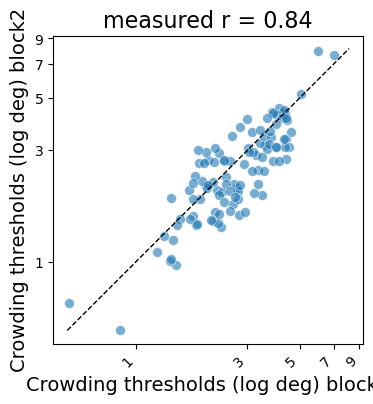

In [55]:
plot_scatter_with_correlation(crowding_gmean_block_cleaned_df[crowding_gmean_block_cleaned_df['repeat']==1]['gmean_threshold_block'],
                              crowding_gmean_block_cleaned_df[crowding_gmean_block_cleaned_df['repeat']==2]['gmean_threshold_block'], 
                              'Crowding thresholds (log deg) block1', 'Crowding thresholds (log deg) block2', plotXequalsY_bool=True)

Min and max values: min_x: -0.4322539585, max_x: 0.950354103, min_y: -0.4087124225, max_y: 1.04075982


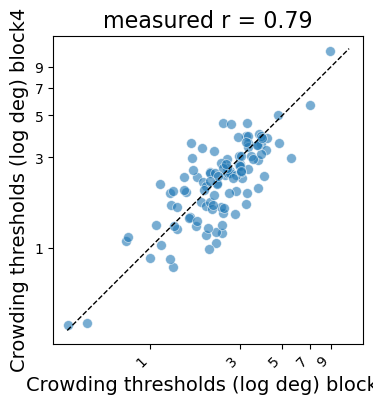

In [56]:
plot_scatter_with_correlation(crowding_gmean_block_cleaned_df[crowding_gmean_block_cleaned_df['repeat']==3]['gmean_threshold_block'],
                              crowding_gmean_block_cleaned_df[crowding_gmean_block_cleaned_df['repeat']==4]['gmean_threshold_block'], 
                              'Crowding thresholds (log deg) block3', 'Crowding thresholds (log deg) block4', plotXequalsY_bool=True)


Min and max values: min_x: 2.5235793143836434, max_x: 3.4836478153836437, min_y: 2.6731146023836434, max_y: 3.4836478153836437


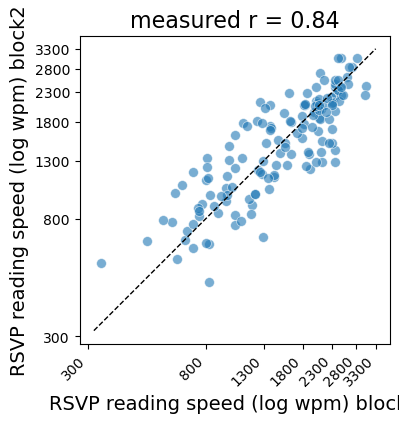

In [57]:
plot_scatter_with_correlation(rsvp_gmean_block_cleaned_df[rsvp_gmean_block_cleaned_df['repeat']==1]['gmean_threshold_block'],
                              rsvp_gmean_block_cleaned_df[rsvp_gmean_block_cleaned_df['repeat']==2]['gmean_threshold_block'], 
                              'RSVP reading speed (log wpm) block1', 'RSVP reading speed (log wpm) block2', plotXequalsY_bool=True,
                              myticks = np.linspace(300,3300,7))


Min and max values: min_x: 2.0150021020110365, max_x: 3.064826648227821, min_y: 1.9831391354309837, max_y: 2.7901056705794165


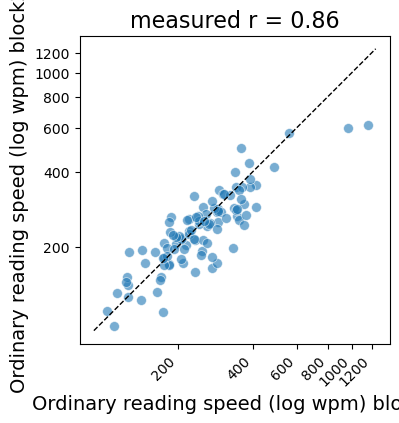

In [58]:
plot_scatter_with_correlation(reading_gmean_block_cleaned_df[reading_gmean_block_cleaned_df['repeat']==1]['gmean_threshold_block'],
                              reading_gmean_block_cleaned_df[reading_gmean_block_cleaned_df['repeat']==2]['gmean_threshold_block'], 
                              'Ordinary reading speed (log wpm) block1', 'Ordinary reading speed (log wpm) block2', plotXequalsY_bool=True,
                              myticks=np.linspace(200,1200,6))


## Is there left-right asymmetry?

In [59]:
# plot_scatter_with_correlation(df_subj_avg, "crowding_R8", "crowding_L8", 
#                               'Crowding, right vs. left', plotXequalsY_bool=True)

In [60]:
# plot_scatter_with_correlation(df_subj_avg, "acuity_R8", "acuity_L8", 
#                               'Letter acuity, right vs. left', plotXequalsY_bool=True)

## Correlation between tasks

### Scatter plots with measured R

In [61]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats
# import statsmodels.api as sm
# from matplotlib.ticker import FixedLocator, FixedFormatter

# def plot_scatter_with_correlation2(var_x, var_y, var_x_name, var_y_name, 
# 								    plotXequalsY_bool=False, equal_axes_bool=True,
# 									myticks_x=np.linspace(1, 9, 5),myticks_y=np.linspace(300,3300,7),
# 									plot_best_fit_bool=True):
# 	"""
# 	Plots a scatter plot of two variables from a DataFrame and computes Pearson's r.

# 	Parameters:
# 		var_x (list): first variable extracted from a df (log10 values expected)
# 		var_y (list): second variable extracted from a df (log10 values expected)
# 	"""
# 	var_x = np.array(var_x)
# 	var_y = np.array(var_y)

# 	# print out minimum and maximum values of the variables
# 	min_x = np.nanmin(var_x)
# 	min_y = np.nanmin(var_y)
# 	max_x = np.nanmax(var_x)
# 	max_y = np.nanmax(var_y)
# 	print(f'Min and max values: min_x: {min_x}, max_x: {max_x}, min_y: {min_y}, max_y: {max_y}')
# 	# Separate axis limits (log10 space with padding)
# 	min_x_val = min_x - abs(min_x) * 0.1
# 	max_x_val = max_x + abs(max_x) * 0.1

# 	min_y_val = min_y - abs(min_y) * 0.1
# 	max_y_val = max_y + abs(max_y) * 0.1

# 	# Compute Pearson correlation
# 	valid = (~np.isnan(var_x)) & (~np.isnan(var_y))
# 	r, p_value = stats.pearsonr(var_x[valid], var_y[valid])

# 	# Determine axis limits (same for both axes, log10 space)
# 	min_val = min(min_x, min_y)
# 	min_val = min_val - abs(min_val) * 0.01
# 	max_val = max(max_x, max_y)
# 	max_val = max_val + abs(max_val) * 0.01

# 	# Create the scatter plot
# 	fig, ax = plt.subplots(figsize=(4, 4))
# 	ax = plt.gca()
# 	sns.scatterplot(x=10**var_x, y=10**var_y, s=50, alpha=0.6, ax=ax)

# 	# ---- Best-fit line + CI in log10 space, plotted on log axes ----
# 	if plot_best_fit_bool:
# 		# ensure we have enough data
# 		valid = (~np.isnan(var_x)) & (~np.isnan(var_y))
# 		if valid.sum() >= 2:
# 			import statsmodels.api as sm

# 			# fit y_log = b0 + b1 * x_log  (your var_x/var_y are already log10)
# 			X = sm.add_constant(var_x[valid])
# 			model = sm.OLS(var_y[valid], X).fit()

# 			# use your padded min/max (log space) to span the plotted range
# 			x_pred_log = np.linspace(min_x_val, max_x_val, 200)
# 			X_pred = sm.add_constant(x_pred_log)
# 			pred = model.get_prediction(X_pred).summary_frame(alpha=0.05)

# 			y_hat_log = pred['mean'].to_numpy()
# 			y_lo_log  = pred['mean_ci_lower'].to_numpy()
# 			y_hi_log  = pred['mean_ci_upper'].to_numpy()

# 			# convert to linear for plotting on log axes
# 			x_pred = 10**x_pred_log
# 			y_hat  = 10**y_hat_log
# 			y_lo   = 10**y_lo_log
# 			y_hi   = 10**y_hi_log

# 			# set limits BEFORE plotting lines to avoid clipping (log scale)
# 			ax.set_xscale("log")
# 			ax.set_yscale("log")

# 			# if you want the same range padding applied to the line visibility
# 			ax.set_xlim(10**min_x, 10**max_x)
# 			ax.set_ylim(10**min_y, 10**max_y)

# 			# draw CI then the line, with high zorder so it’s on top of points
# 			ax.fill_between(x_pred, y_lo, y_hi, alpha=0.2, linewidth=0, zorder=3)
# 			ax.plot(x_pred, y_hat, linewidth=2, zorder=4)

# 	# Equal aspect handling (works on log axes)
# 	if equal_axes_bool:
# 		ax.set_aspect('equal', adjustable='box')
# 		plt.axis('equal')
# 	else:
# 		ax.set_aspect('auto', adjustable='box')

# 	# Title with r
# 	plt.title(f"measured r = {r:.2f}", fontsize=16)

# 	# Labels
# 	plt.xlabel(var_x_name, fontsize=14)
# 	plt.ylabel(var_y_name, fontsize=14)
# 	plt.xticks(fontsize=10)
# 	plt.yticks(fontsize=10)


# 	# Set limits after plotting
# 	plt.xlim(10**min_x_val, 10**max_x_val)
# 	plt.ylim(10**min_y_val, 10**max_y_val)
# 	# x = y reference (use your log-space min/max)
# 	if plotXequalsY_bool:
# 		ax.plot([10**min_val, 10**max_val], [10**min_val, 10**max_val],
# 				color="black", linestyle="--", linewidth=1, zorder=2)

# 	# # Identical integer ticks you specified
# 	xticks = np.round(myticks_x).astype(int)
# 	yticks = np.round(myticks_y).astype(int)
# 	ax.xaxis.set_major_locator(FixedLocator(xticks))
# 	ax.xaxis.set_major_formatter(FixedFormatter([str(t) for t in xticks]))
# 	ax.yaxis.set_major_locator(FixedLocator(yticks))
# 	ax.yaxis.set_major_formatter(FixedFormatter([str(t) for t in yticks]))
# 	ax.xaxis.set_minor_locator(FixedLocator([]))
# 	ax.yaxis.set_minor_locator(FixedLocator([]))

# 	plt.xticks(rotation=45, ha="right")
# 	plt.show()


In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import FixedLocator, FixedFormatter

def plot_scatter_with_correlation2(var_x, var_y, var_x_name, var_y_name, 
                                   plotXequalsY_bool=False, equal_axes_bool=True,
                                   myticks_x=np.linspace(1, 9, 5), myticks_y=np.linspace(300,3300,7),
                                   plot_best_fit_bool=True,
                                   n_boot=2000, random_state=None):
    """
    Plots a scatter plot (linear units) of two log10 variables and computes Pearson's r in log space.
    If plot_best_fit_bool=True, draws the best-fit line (log-log) and a 68% bootstrap CI band (16th–84th).
    """
    var_x = np.array(var_x, dtype=float)
    var_y = np.array(var_y, dtype=float)

    # Print ranges (in log10)
    min_x = np.nanmin(var_x); max_x = np.nanmax(var_x)
    min_y = np.nanmin(var_y); max_y = np.nanmax(var_y)
    print(f'Min and max values: min_x: {min_x}, max_x: {max_x}, min_y: {min_y}, max_y: {max_y}')

    # 10% padding in log space
    min_x_val = min_x - abs(min_x) * 0.1
    max_x_val = max_x + abs(max_x) * 0.1
    min_y_val = min_y - abs(min_y) * 0.1
    max_y_val = max_y + abs(max_y) * 0.1

    # Pearson r (log space)
    valid = (~np.isnan(var_x)) & (~np.isnan(var_y))
    if valid.sum() < 2:
        r, p_value = np.nan, np.nan
    else:
        r, p_value = stats.pearsonr(var_x[valid], var_y[valid])

    # Joint range (for x=y line)
    min_val = min(min_x, min_y) - abs(min(min_x, min_y)) * 0.01
    max_val = max(max_x, max_y) + abs(max(max_x, max_y)) * 0.01

    # Scatter (plot in linear units; axes will be log-scaled)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax = plt.gca()
    sns.scatterplot(x=10**var_x, y=10**var_y, s=50, alpha=0.6, ax=ax)

    # ----- Best-fit line + 68% bootstrap CI (fit in log space) -----
    if plot_best_fit_bool and valid.sum() >= 2:
        x_log = var_x[valid]
        y_log = var_y[valid]

        # Grid to predict on (log space), then convert to linear for plotting
        x_pred_log = np.linspace(min_x_val, max_x_val, 200)

        # Closed-form OLS in log space for the original line
        # slope, intercept from polyfit in log space
        b1, b0 = np.polyfit(x_log, y_log, 1)
        y_hat_log = b0 + b1 * x_pred_log

        # ---- Bootstrap 68% CI (16th–84th percentiles) ----
        rng = np.random.default_rng(random_state)
        n = x_log.size
        boot_preds = np.empty((n_boot, x_pred_log.size), dtype=float)

        # Vectorized-ish bootstrap: resample indices; fit line in log space; predict
        for i in range(n_boot):
            idx = rng.integers(0, n, size=n)
            xb = x_log[idx]
            yb = y_log[idx]
            # Guard against degenerate samples (all xb equal)
            if np.allclose(xb, xb[0]):
                # fallback: use original fit for this draw
                boot_preds[i, :] = y_hat_log
                continue
            b1_b, b0_b = np.polyfit(xb, yb, 1)
            boot_preds[i, :] = b0_b + b1_b * x_pred_log

        # 68% central interval in log space, then convert to linear
        y_lo_log = np.percentile(boot_preds, 16, axis=0)
        y_hi_log = np.percentile(boot_preds, 84, axis=0)

        x_pred = 10**x_pred_log
        y_hat  = 10**y_hat_log
        y_lo   = 10**y_lo_log
        y_hi   = 10**y_hi_log

        # Log axes
        ax.set_xscale("log")
        ax.set_yscale("log")

        # Draw CI band first, then the line
        ax.fill_between(x_pred, y_lo, y_hi, alpha=0.25, linewidth=0, zorder=3)
        ax.plot(x_pred, y_hat, linewidth=2, zorder=4)

    # Aspect
    if equal_axes_bool:
        ax.set_aspect('equal', adjustable='box')
        plt.axis('equal')
    else:
        ax.set_aspect('auto', adjustable='box')

    # Title & labels
    plt.title(f"measured r = {r:.2f}" if np.isfinite(r) else "measured r = N/A", fontsize=16)
    plt.xlabel(var_x_name, fontsize=14)
    plt.ylabel(var_y_name, fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Final padded limits (linear units)
    plt.xlim(10**min_x_val, 10**max_x_val)
    plt.ylim(10**min_y_val, 10**max_y_val)

    # Optional x=y reference in linear units
    if plotXequalsY_bool:
        ax.plot([10**min_val, 10**max_val], [10**min_val, 10**max_val],
                color="black", linestyle="--", linewidth=1, zorder=2)

    # Manual ticks (fixed positions on log axes)
    xticks = np.round(myticks_x).astype(int)
    yticks = np.round(myticks_y).astype(int)
    ax.xaxis.set_major_locator(FixedLocator(xticks))
    ax.xaxis.set_major_formatter(FixedFormatter([str(t) for t in xticks]))
    ax.yaxis.set_major_locator(FixedLocator(yticks))
    ax.yaxis.set_major_formatter(FixedFormatter([str(t) for t in yticks]))
    ax.xaxis.set_minor_locator(FixedLocator([]))
    ax.yaxis.set_minor_locator(FixedLocator([]))

    plt.xticks(rotation=45, ha="right")
    plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Min and max values: min_x: -0.29858858325, max_x: 0.929864890375, min_y: 2.633234086383643, max_y: 3.4673504953836436


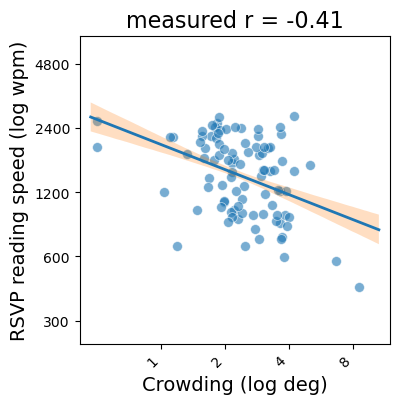

In [92]:
plot_scatter_with_correlation2(big_df['crowding_grandMean'],
                              big_df['rsvp_grandMean'], 
                              'Crowding (log deg)', 'RSVP reading speed (log wpm)',
							  myticks_x=[1, 2, 4, 8],myticks_y=[300, 600, 1200, 2400, 4800])


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Min and max values: min_x: -0.29858858325, max_x: 0.929864890375, min_y: 2.012808706739162, max_y: 2.927466159403618


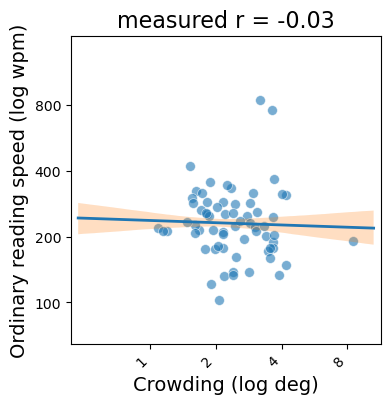

In [94]:
plot_scatter_with_correlation2(big_df['crowding_grandMean'],
                              big_df['reading_grandMean'], 
                              'Crowding (log deg)', 'Ordinary reading speed (log wpm)',
									myticks_x=[1, 2, 4, 8],myticks_y=[100, 200, 400, 800])
									


Min and max values: min_x: nan, max_x: nan, min_y: nan, max_y: nan


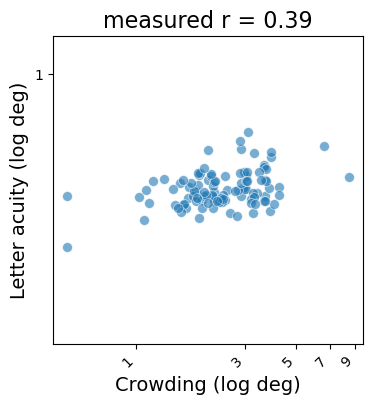

In [65]:
plot_scatter_with_correlation(big_df['crowding_grandMean'],
                              big_df['acuity_grandMean'], 
                              'Crowding (log deg)', 'Letter acuity (log deg)')

Min and max values: min_x: nan, max_x: nan, min_y: nan, max_y: nan


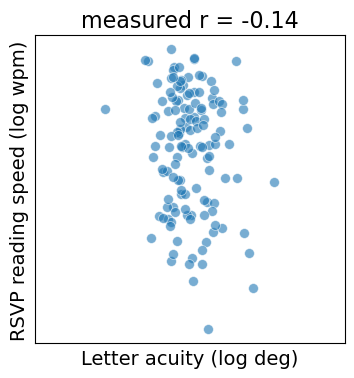

In [66]:
plot_scatter_with_correlation(big_df['acuity_grandMean'],
                              big_df['rsvp_grandMean'], 
                              'Letter acuity (log deg)', 'RSVP reading speed (log wpm)')

Min and max values: min_x: nan, max_x: nan, min_y: nan, max_y: nan


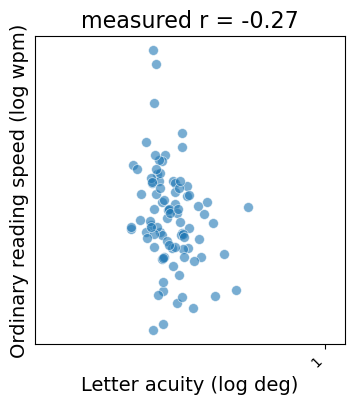

In [67]:
plot_scatter_with_correlation(big_df['acuity_grandMean'],
                              big_df['reading_grandMean'], 
                              'Letter acuity (log deg)', 'Ordinary reading speed (log wpm)')

### Calculate and display measured and corrected R

#### Functions:

In [68]:
def summarize_task(X):
    """
    df_task: long df with columns ['prolificID','repeat','gmean_threshold_block'] (taskName can be present/ignored)
    Returns a Series with within/between variances, grand mean, and noise ceiling.
    """

    # per-participant mean across repeats
    subj_mean = X.mean(axis=1, skipna=True)

    # stats
    within_var = X.var(axis=1, ddof=1).mean(skipna=True)
    between_var = np.nanvar(subj_mean.to_numpy(), ddof=1)
    grand_mean = subj_mean.mean(skipna=True)

    # split-half reliability → Spearman–Brown
    if X.shape[1] < 2:
        r_ceiling = np.nan
    else:
        n = X.shape[1]
        first, last = X.iloc[:, :n//2].mean(axis=1), X.iloc[:, n//2:].mean(axis=1)
        odd, even  = X.iloc[:, 1::2].mean(axis=1), X.iloc[:, 0::2].mean(axis=1)

        def r(a,b):
            a, b = a.to_numpy(), b.to_numpy()
            m = np.isfinite(a) & np.isfinite(b)
            return np.nan if m.sum() < 3 else stats.pearsonr(a[m], b[m])[0]

        r_FL, r_OE = r(first,last), r(odd,even)
        r_i = np.sqrt(r_FL * r_OE) if np.isfinite(r_FL) and np.isfinite(r_OE) else np.nan
        if np.isnan(r_i):
            r_ceiling = np.nan
        else:
            r_i = float(np.clip(r_i, 0.0, 0.999999))
            r_ceiling = (2 * r_i) / (1 + r_i)

    return pd.Series({
        "within_subj_variance": within_var,
        "btw_subj_variance": between_var,
        "mean": grand_mean,
        "r(test,retest)": r_i,
        "r_ceiling": r_ceiling
    })

def summarize_many(task_dfs):
    """
    task_dfs: dict like {'acuity': df_acuity, 'crowding': df_crowding, ...}
    Returns one row per task.
    """
    rows = []
    for task, df_task_wide in task_dfs.items():
        s = summarize_task(df_task_wide)
        s.name = task
        rows.append(s)
    return pd.DataFrame(rows).reset_index(names="task")

def pivot_for_summarize(df, columnNames="repeat", valueNames="gmean_threshold_block"):
    """
    df: long df with columns ['prolificID','taskName','repeat','gmean_threshold_block']
    returns: wide df with one row per participant and one column per repeat
    """
    X = df.pivot(index="prolificID", columns=columnNames, values=valueNames).sort_index(axis=1)
    return X


In [69]:
def print_measured_corrected_r(df, var_x, var_y, r_ceiling_x, r_ceiling_y):
    """
    Compute and print measured and corrected Pearson correlations between two variables.

    Parameters:
        df (pd.DataFrame): Data containing the variables.
        var_x (str): Name of the first variable (x-axis).
        var_y (str): Name of the second variable (y-axis).
        r_ceiling_x (float): Noise ceiling (reliability) for var_x.
        r_ceiling_y (float): Noise ceiling (reliability) for var_y.

    Returns:
        pd.DataFrame: Single-row dataframe with results.
    """
    df = df.copy()
    
    # Filter for non-NaN pairs
    valid_mask = df[[var_x, var_y]].notna().all(axis=1)
    x_vals = df.loc[valid_mask, var_x]
    y_vals = df.loc[valid_mask, var_y]

    # Compute measured correlation
    r_measured, p_value = stats.pearsonr(x_vals, y_vals)

    # Compute combined noise ceiling
    r_ceiling_combined = np.sqrt(r_ceiling_x * r_ceiling_y)

    # Apply correction
    r_corrected = r_measured / r_ceiling_combined

    # Return results in dataframe form
    return pd.DataFrame({
        'var_x': [var_x],
        'var_y': [var_y],
        'noise_ceiling_x': [r_ceiling_x],
        'noise_ceiling_y': [r_ceiling_y],
        'noise_ceiling_combined': [r_ceiling_combined],
        'r_measured': [r_measured],
        'r_corrected': [r_corrected]
    })


In [70]:
def create_corr_df(df_data, df_r_ceiling, var_ceiling_pairs):
    """
    Create a correlation matrix for the given DataFrame and noise ceiling DataFrame.

    Parameters:
        df_data (pd.DataFrame): DataFrame containing the data to correlate.
        df_r_ceiling (pd.DataFrame): DataFrame containing the noise ceilings.
        var_ceiling_pairs (dict): Dictionary mapping variable names to their noise ceiling names.
        log10_bool (bool): Whether to apply log10 transformation to the data.

    Returns:
        pd.DataFrame: Correlation matrix with measured and corrected correlations.
    """
    df_data = df_data.copy()
    df_r_ceiling = df_r_ceiling.copy()
    results = []
    
    for var_x, var_y in itertools.combinations(df_data.columns, 2):
        r_ceiling_x = df_r_ceiling.loc[df_r_ceiling['task'] == var_ceiling_pairs[var_x], 'r_ceiling'].values[0]
        r_ceiling_y = df_r_ceiling.loc[df_r_ceiling['task'] == var_ceiling_pairs[var_y], 'r_ceiling'].values[0]
        
        result = print_measured_corrected_r(
            df_data,
            var_x=var_x,
            var_y=var_y,
            r_ceiling_x=r_ceiling_x,
            r_ceiling_y=r_ceiling_y
        )
        
        results.append(result)

    return pd.concat(results, ignore_index=True)

In [71]:
def create_corr_mtx(df_long, all_tasks_summary, var_ceiling_pairs, value_col="r_measured"):

    vars_all = sorted(set(df_long["var_x"]).union(df_long["var_y"]))
    R = pd.DataFrame(np.nan, index=vars_all, columns=vars_all, dtype=float)

    for _, row in df_long.iterrows():
        x, y, val = row["var_x"], row["var_y"], row[value_col]
        R.loc[x, y] = val
        R.loc[y, x] = val


    # map each matrix label to its task name
    tasks_for_vars = pd.Index(R.index).map(var_ceiling_pairs)
    # pull the corresponding r(test,retest) values
    diag_series = all_tasks_summary.set_index("task")["r(test,retest)"]
    diag_vals = diag_series.reindex(tasks_for_vars).to_numpy()
    # write to the diagonal
    ii = np.diag_indices_from(R.values)
    R.values[ii] = diag_vals

    # np.fill_diagonal(R.values, 1.0)
    return R


def plot_mtx_heatmap(R, title=None, mask_upper=True, fontSize=10,
                    valmin=-1, valmax=1, colormap="RdBu_r"):
    """
    Plot a heatmap from the long correlation table.
    
    Parameters:
        df_long: output from create_corr_df(...)
        value_col: 'r_measured' or 'r_corrected'
        mask_upper: True = show only lower triangle for readability
    """

    mask = None
    if mask_upper:
        mask = np.zeros_like(R, dtype=bool)
        mask[np.triu_indices_from(mask, k=1)] = True  # mask above-diagonal

    plt.figure(figsize=(9, 8))
    ax = sns.heatmap(
        R, annot=True, fmt=".2f", cmap=colormap,
        vmin=valmin, vmax=valmax, square=True, #, center=0
        mask=mask, cbar_kws={"label": "r"},
        annot_kws={"size": fontSize}
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(title, fontsize=16)
    plt.tight_layout()
    plt.show()



#### Correlations between tasks

In [72]:
block_dfs = {
    "acuity": big_df[[col for col in big_df.columns if (col.startswith("acuity_")) & (not col.endswith("_grandMean"))]],
    "crowding": big_df[[col for col in big_df.columns if (col.startswith("crowding_")) & (not col.endswith("_grandMean"))]],
    "rsvp": big_df[[col for col in big_df.columns if (col.startswith("rsvp_")) & (not col.endswith("_grandMean"))]],
    "reading": big_df[[col for col in big_df.columns if (col.startswith("reading_")) & (not col.endswith("_grandMean"))]]
}

# Summarize all tasks at once
all_tasks_summary = summarize_many(block_dfs)
pd.options.display.float_format = '{:.2f}'.format
display(all_tasks_summary)


,task,within_subj_variance,btw_subj_variance,mean,"r(test,retest)",r_ceiling
0,acuity,0.00,0.01,-0.50,0.72,0.84
1,crowding,0.01,0.03,0.38,0.88,0.94
2,rsvp,0.01,0.03,3.17,0.84,0.91
3,reading,0.00,0.03,2.38,0.86,0.93


In [73]:
cols = [c for c in big_df.columns if c.endswith('grandMean')]
cols = ['prolificID'] + cols
all_tasks_cleaned_wide = big_df[cols].set_index("prolificID")
# display(all_tasks_cleaned_wide.head())

In [74]:
var_ceiling_pairs_task = {
    'acuity_grandMean': 'acuity',
    'crowding_grandMean': 'crowding',
    'rsvp_grandMean': 'rsvp',
    'reading_grandMean': 'reading'
}
corr_df = create_corr_df(all_tasks_cleaned_wide, all_tasks_summary, var_ceiling_pairs_task)
display(corr_df)

,var_x,var_y,noise_ceiling_x,noise_ceiling_y,noise_ceiling_combined,r_measured,r_corrected
0,acuity_grandMean,crowding_grandMean,0.84,0.94,0.89,0.39,0.44
1,acuity_grandMean,rsvp_grandMean,0.84,0.91,0.87,-0.14,-0.16
2,acuity_grandMean,reading_grandMean,0.84,0.93,0.88,-0.27,-0.30
3,crowding_grandMean,rsvp_grandMean,0.94,0.91,0.93,-0.41,-0.44
4,crowding_grandMean,reading_grandMean,0.94,0.93,0.93,-0.03,-0.04
5,rsvp_grandMean,reading_grandMean,0.91,0.93,0.92,0.48,0.52


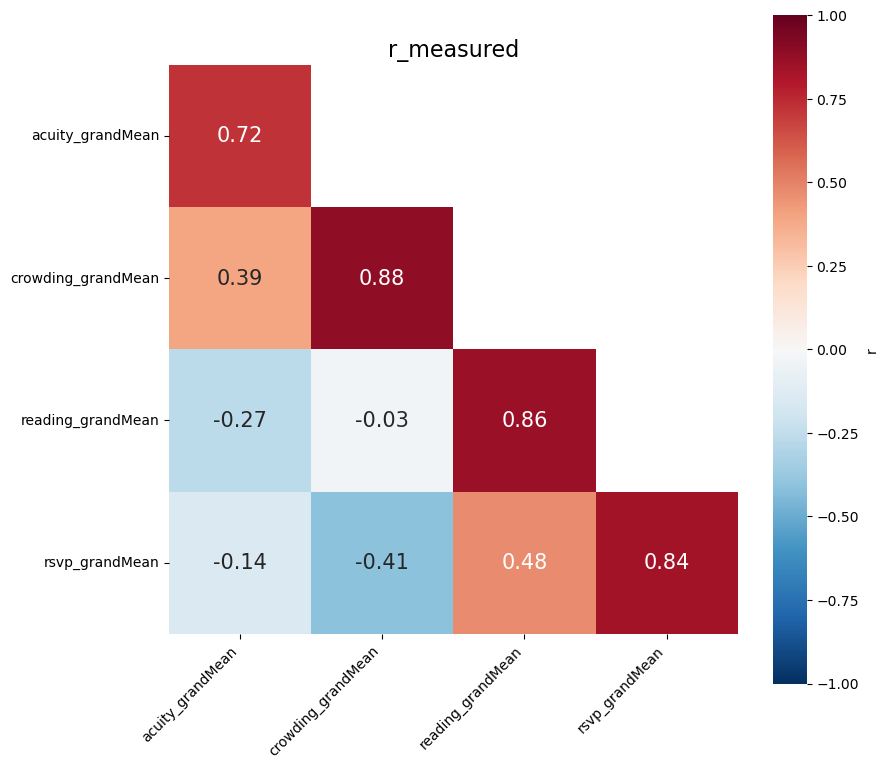

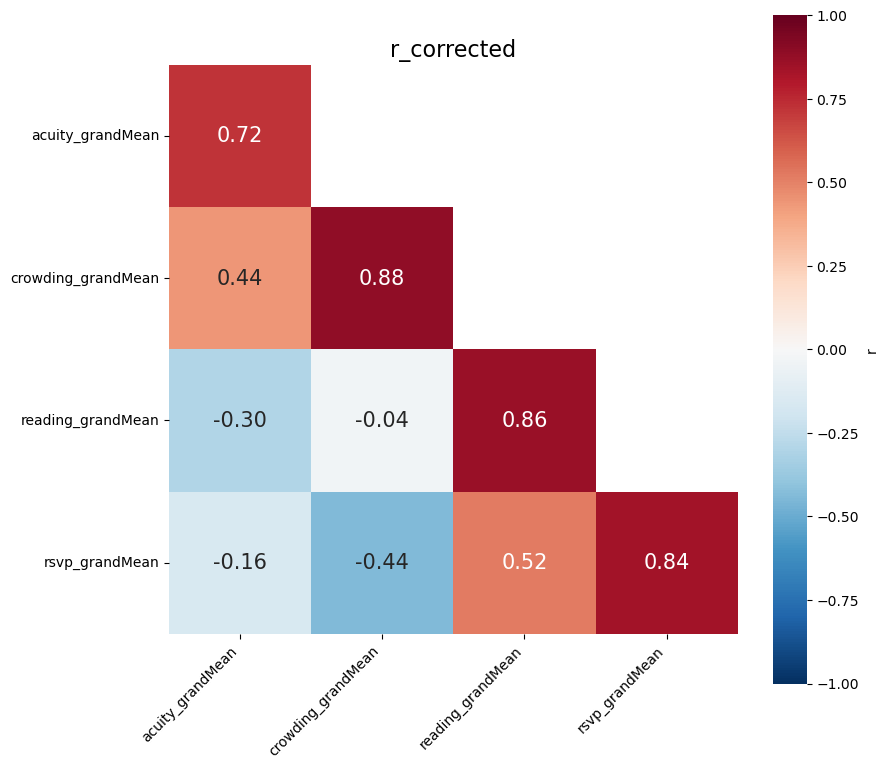

In [75]:
corr_mtx_r_measured = create_corr_mtx(corr_df, all_tasks_summary, var_ceiling_pairs_task, value_col="r_measured")
plot_mtx_heatmap(corr_mtx_r_measured, title='r_measured', fontSize=15)
corr_mtx_r_corrected = create_corr_mtx(corr_df, all_tasks_summary, var_ceiling_pairs_task, value_col="r_corrected")
plot_mtx_heatmap(corr_mtx_r_corrected, title='r_corrected', fontSize=15)

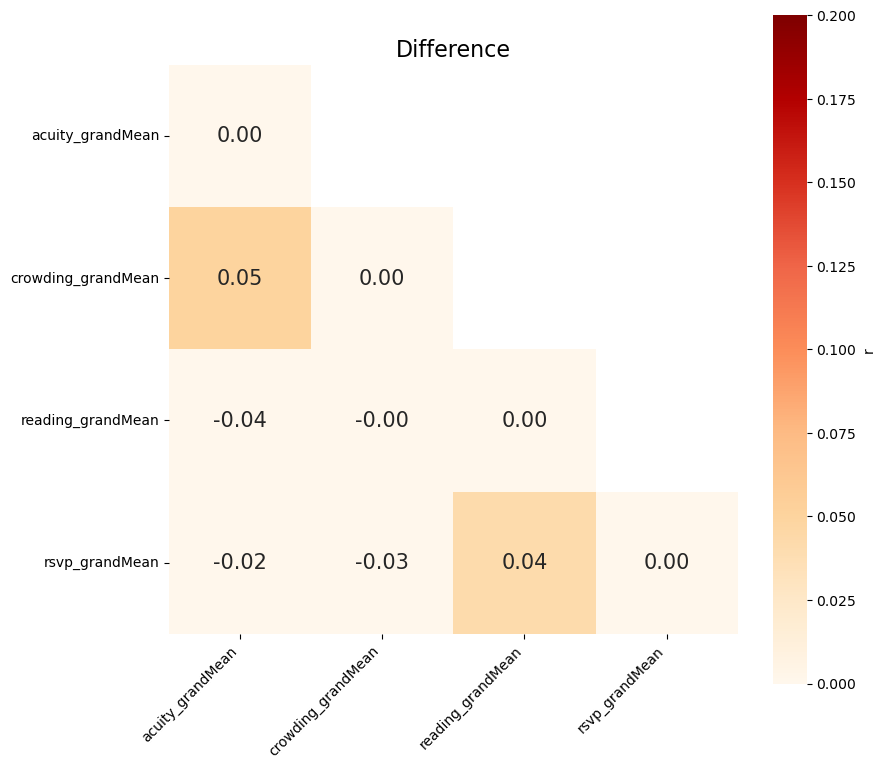

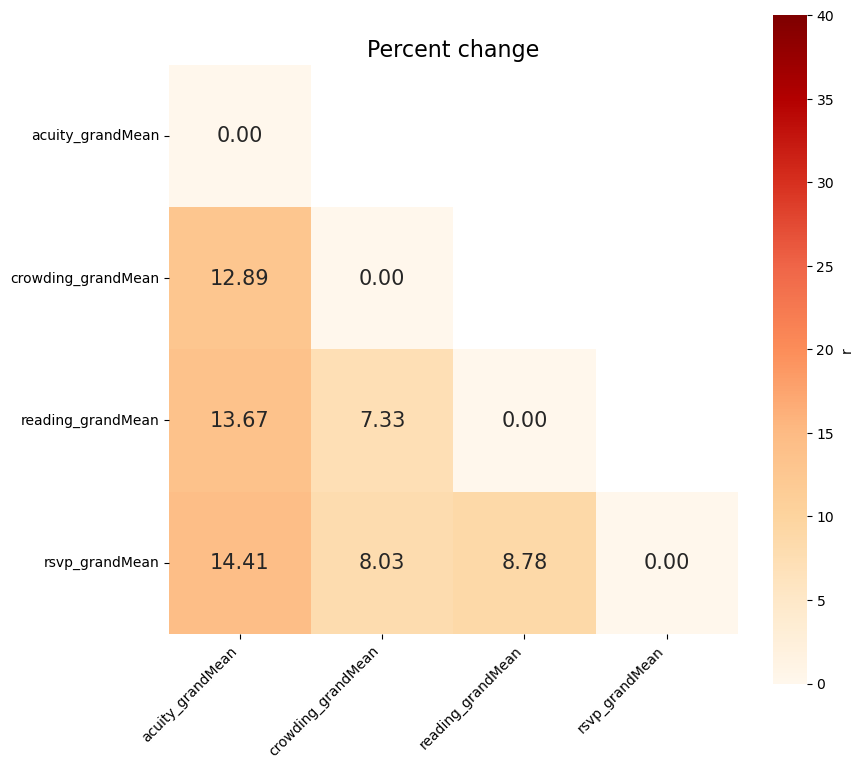

In [76]:
difference_mtx = corr_mtx_r_corrected - corr_mtx_r_measured 
plot_mtx_heatmap(difference_mtx, title='Difference', fontSize=15, valmin=0, valmax=0.2, colormap='OrRd')
percentchange_mtx = (corr_mtx_r_corrected - corr_mtx_r_measured) / corr_mtx_r_measured * 100
plot_mtx_heatmap(percentchange_mtx, title='Percent change', fontSize=15, valmin=0, valmax=40, colormap='OrRd')


# Additional analyses

## Ordinary reading plots, each psg separately

In [77]:
display(df_reading_allThresh_cleaned)

,prolificID,conditionName,taskName,meridian,repeat,threshold,numTrialsSent,questSD,readingCQAccuracy
1183,5f0788c06b220f03231666a0,reading_Beaver_block1,reading,first,1,2.69,NaN,NaN,100.00
1184,5f0788c06b220f03231666a0,reading_Winter_block2,reading,second,1,2.68,NaN,NaN,100.00
1185,64837ba51422d817b62cc5cc,reading_Beaver_block1,reading,first,1,2.39,NaN,NaN,80.00
1186,64837ba51422d817b62cc5cc,reading_Winter_block2,reading,second,1,2.30,NaN,NaN,60.00
1187,6778842e3f7e2e62756f7178,reading_Beaver_block1,reading,first,1,2.35,NaN,NaN,80.00
...,...,...,...,...,...,...,...,...,...
3025,5d7bde81c7390f00169b2fdf,reading_Islands_block2,reading,second,2,2.44,NaN,NaN,80.00
3026,5f98099d48060d0450394002,reading_Desert_block1,reading,first,2,2.43,NaN,NaN,100.00
3027,5f98099d48060d0450394002,reading_Islands_block2,reading,second,2,2.46,NaN,NaN,100.00
3028,5fb281433a31c686f0ec3ecb,reading_Desert_block1,reading,first,2,2.68,NaN,NaN,60.00


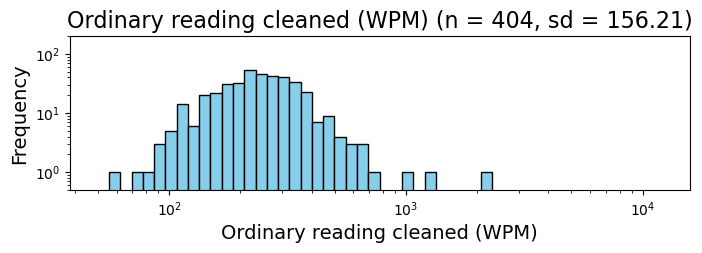

In [78]:
# ordinary reading
# df_reading_allThresh_raw = df_both_sessions[df_both_sessions['taskName'] == 'reading']
# df_reading_allThresh_cleaned = filter_excluding_ids(df_reading_allThresh_raw, reading_low_accuracy_ids, reading_bad_ratio_ids)
plot_threshold_array(df_reading_allThresh_cleaned['threshold'], 'Ordinary reading cleaned (WPM)', num_bins=50, min_val=50, max_val=12000)

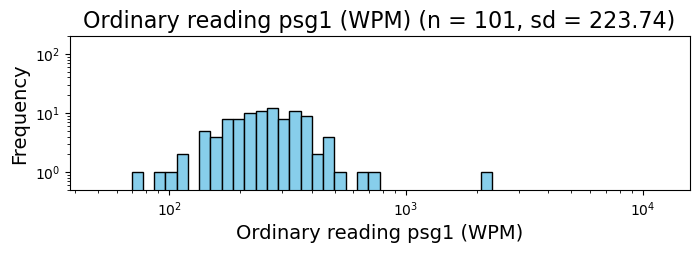

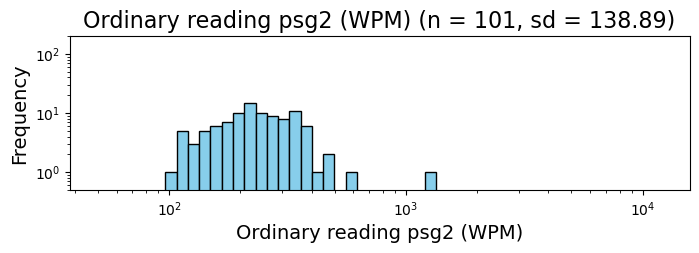

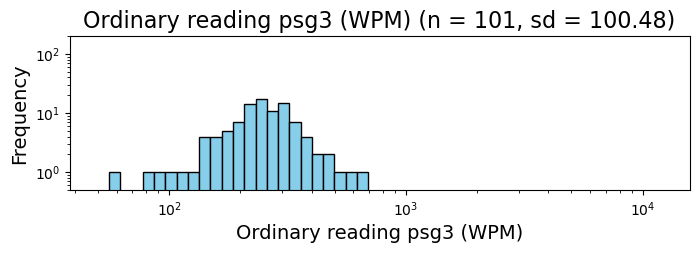

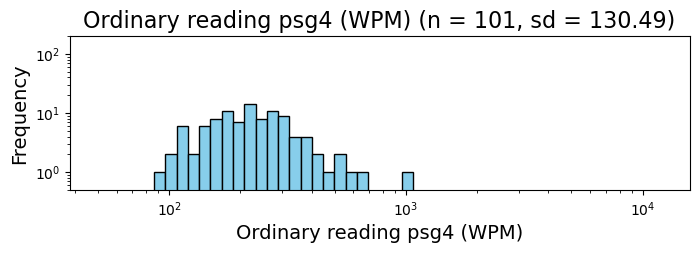

In [79]:
plot_threshold_array(df_reading_allThresh_cleaned[(df_reading_allThresh_cleaned['meridian'] == 'first') & (df_reading_allThresh_cleaned['repeat'] == 1)]['threshold'], 
                     'Ordinary reading psg1 (WPM)', num_bins=50, min_val=50, max_val=12000)
plot_threshold_array(df_reading_allThresh_cleaned[(df_reading_allThresh_cleaned['meridian'] == 'second') & (df_reading_allThresh_cleaned['repeat'] == 1)]['threshold'], 
                     'Ordinary reading psg2 (WPM)', num_bins=50, min_val=50, max_val=12000)
plot_threshold_array(df_reading_allThresh_cleaned[(df_reading_allThresh_cleaned['meridian'] == 'first') & (df_reading_allThresh_cleaned['repeat'] == 2)]['threshold'], 
                     'Ordinary reading psg3 (WPM)', num_bins=50, min_val=50, max_val=12000)
plot_threshold_array(df_reading_allThresh_cleaned[(df_reading_allThresh_cleaned['meridian'] == 'second') & (df_reading_allThresh_cleaned['repeat'] == 2)]['threshold'], 
                     'Ordinary reading psg4 (WPM)', num_bins=50, min_val=50, max_val=12000)

## Correlations, R and L thresholds

### Calculate r ceiling

In [80]:
# # summary, coming from all thresholds, separating by meridian/passage
# indThresh_dfs = {
#     "acuity": pivot_for_summarize(acuity_indThresh_cleaned_df, columnNames=['repeat','meridian'], valueNames='threshold'),
#     "crowding": pivot_for_summarize(crowding_indThresh_cleaned_df, columnNames=['repeat','meridian'], valueNames='threshold'),
#     "rsvp": pivot_for_summarize(rsvp_indThresh_cleaned_df, columnNames=['repeat','meridian'], valueNames='threshold'),
#     "reading": pivot_for_summarize(reading_indThresh_cleaned_df, columnNames=['repeat','meridian'], valueNames='threshold')
# }

# # Summarize all tasks at once
# all_tasks_summary_from_indThresh = summarize_many(indThresh_dfs)
# print(all_tasks_summary_from_indThresh)

In [81]:
# # summary, coming from only 1 test and 1 retest for each threshold, separating by meridian/passage
# indThresh_dfs_truncated = {
#     "acuity": pivot_for_summarize(acuity_indThresh_cleaned_df, columnNames=['repeat','meridian'], valueNames='threshold'),
#     "crowding": pivot_for_summarize(crowding_indThresh_cleaned_df[(crowding_indThresh_cleaned_df['repeat'] == 1) | (crowding_indThresh_cleaned_df['repeat'] == 2)], columnNames=['repeat','meridian'], valueNames='threshold'),
#     "rsvp": pivot_for_summarize(rsvp_indThresh_cleaned_df, columnNames=['repeat','meridian'], valueNames='threshold'),
#     "reading": pivot_for_summarize(reading_indThresh_cleaned_df[reading_indThresh_cleaned_df['repeat'] == 1], columnNames=['repeat','meridian'], valueNames='threshold')
# }

# # Summarize all tasks at once
# all_tasks_summary_from_indThresh_truncated = summarize_many(indThresh_dfs_truncated)
# print(all_tasks_summary_from_indThresh_truncated)

In [82]:
# # summary, coming from all repeats for each threshold, separating by meridian/passage
# indThresh_dfs_meridian = {
#     "acuity_R": pivot_for_summarize(acuity_indThresh_cleaned_df[acuity_indThresh_cleaned_df['meridian'] == 'R8'], valueNames='threshold'),
#     "acuity_L": pivot_for_summarize(acuity_indThresh_cleaned_df[acuity_indThresh_cleaned_df['meridian'] == 'L8'], valueNames='threshold'),
#     "crowding_R": pivot_for_summarize(crowding_indThresh_cleaned_df[crowding_indThresh_cleaned_df['meridian'] == 'R8'], valueNames='threshold'),
#     "crowding_L": pivot_for_summarize(crowding_indThresh_cleaned_df[crowding_indThresh_cleaned_df['meridian'] == 'L8'], valueNames='threshold'),
#     "rsvp": pivot_for_summarize(rsvp_indThresh_cleaned_df, valueNames='threshold'), # rsvp has no meridian
#     "reading_firstpsg": pivot_for_summarize(reading_indThresh_cleaned_df[reading_indThresh_cleaned_df['meridian'] == 'first'], valueNames='threshold'),
#     "reading_secondpsg": pivot_for_summarize(reading_indThresh_cleaned_df[reading_indThresh_cleaned_df['meridian'] == 'second'], valueNames='threshold')

# }

# # Summarize all tasks at once
# all_tasks_summary_from_indThresh_meridian = summarize_many(indThresh_dfs_meridian)
# display(all_tasks_summary_from_indThresh_meridian)

In [83]:
# summary, coming from only 1 test and 1 retest for each threshold, separating by meridian/passage
indThresh_dfs_meridian_truncated = {
    "acuity_R": pivot_for_summarize(acuity_indThresh_cleaned_df[acuity_indThresh_cleaned_df['meridian'] == 'R8'], valueNames='threshold'),
    "acuity_L": pivot_for_summarize(acuity_indThresh_cleaned_df[acuity_indThresh_cleaned_df['meridian'] == 'L8'], valueNames='threshold'),
    "crowding_R": pivot_for_summarize(crowding_indThresh_cleaned_df[(crowding_indThresh_cleaned_df['meridian'] == 'R8')
                                                                    & ((crowding_indThresh_cleaned_df['repeat'] == 1)
                                                                    |  (crowding_indThresh_cleaned_df['repeat'] == 2))], valueNames='threshold'),
    "crowding_L": pivot_for_summarize(crowding_indThresh_cleaned_df[(crowding_indThresh_cleaned_df['meridian'] == 'L8')
                                                                    & ((crowding_indThresh_cleaned_df['repeat'] == 1)
                                                                    |  (crowding_indThresh_cleaned_df['repeat'] == 2))], valueNames='threshold'),
    "rsvp": pivot_for_summarize(rsvp_indThresh_cleaned_df, valueNames='threshold'), # rsvp has no meridian
    "reading_firstpsg": pivot_for_summarize(reading_indThresh_cleaned_df[(reading_indThresh_cleaned_df['meridian'] == 'first')], columnNames=['repeat','meridian'], valueNames='threshold'),
    "reading_secondpsg": pivot_for_summarize(reading_indThresh_cleaned_df[(reading_indThresh_cleaned_df['meridian'] == 'second')], columnNames=['repeat','meridian'], valueNames='threshold')

}

# Summarize all tasks at once
all_tasks_summary_from_indThresh_meridian_truncated = summarize_many(indThresh_dfs_meridian_truncated)
display(all_tasks_summary_from_indThresh_meridian_truncated)

,task,within_subj_variance,btw_subj_variance,mean,"r(test,retest)",r_ceiling
0,acuity_R,0.00,0.01,-0.50,0.62,0.77
1,acuity_L,0.00,0.01,-0.50,0.63,0.78
2,crowding_R,0.02,0.04,0.34,0.68,0.81
3,crowding_L,0.02,0.04,0.46,0.66,0.79
4,rsvp,0.01,0.03,3.17,0.84,0.91
5,reading_firstpsg,0.01,0.03,2.40,0.66,0.79
6,reading_secondpsg,0.01,0.03,2.36,0.71,0.83


### Correlations for all separate measures

In [84]:
var_ceiling_pairs_allthresh = {
    'acuity_L8_block1': 'acuity_L',
    'acuity_L8_block2': 'acuity_L',
    'acuity_R8_block1': 'acuity_R',
    'acuity_R8_block2': 'acuity_R',
    'crowding_L8_block1': 'crowding_L',
    'crowding_L8_block2': 'crowding_L',
    'crowding_R8_block1': 'crowding_R',
    'crowding_R8_block2': 'crowding_R',
    'crowding_L8_block3': 'crowding_L',
    'crowding_L8_block4': 'crowding_L',
    'crowding_R8_block3': 'crowding_R',
    'crowding_R8_block4': 'crowding_R',
    'rsvp_foveal_block1': 'rsvp',
    'rsvp_foveal_block2': 'rsvp',
    'reading_Beaver_block1': 'reading_firstpsg',
    'reading_Desert_block1': 'reading_firstpsg',
    'reading_Winter_block2': 'reading_secondpsg',
    'reading_Islands_block2': 'reading_secondpsg'
}

In [85]:
# corr_mtx_allthresh = create_corr_df(all_tasks_indThresh_cleaned_wide, all_tasks_summary_from_indThresh_meridian, var_ceiling_pairs_allthresh)

In [86]:
# plot_corr_heatmap(corr_mtx_allthresh, all_tasks_summary_from_indThresh_meridian, var_ceiling_pairs_allthresh, value_col="r_measured", fontSize=8)
# plot_corr_heatmap(corr_mtx_allthresh, all_tasks_summary_from_indThresh_meridian, var_ceiling_pairs_allthresh, value_col="r_corrected", fontSize=8)

### Correlations for meridians

In [87]:
all_tasks_meridian_cleaned_wide = all_tasks_meridian_cleaned_wide.set_index("prolificID")

In [88]:
var_ceiling_pairs_meridian = {
    'acuity_L8': 'acuity_L',
    'acuity_R8': 'acuity_R',
    'crowding_L8': 'crowding_L',
    'crowding_R8': 'crowding_R',
    'rsvp_foveal': 'rsvp',
    'reading_first': 'reading_firstpsg',
    'reading_second': 'reading_secondpsg'
    }

In [89]:
corr_meridian_df = create_corr_df(all_tasks_meridian_cleaned_wide, all_tasks_summary_from_indThresh_meridian_truncated, var_ceiling_pairs_meridian)

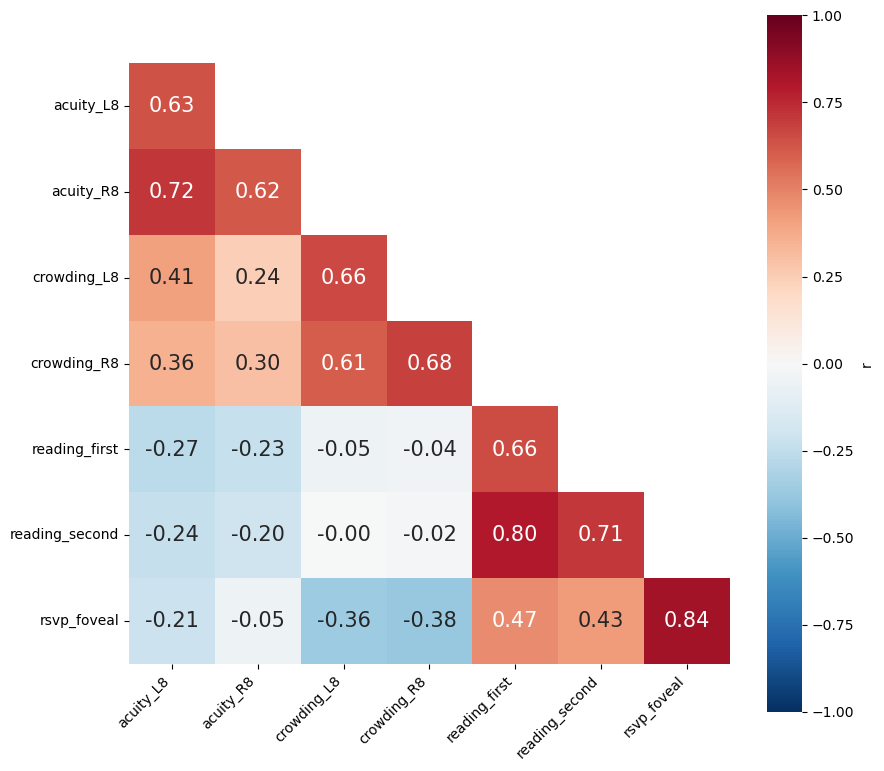

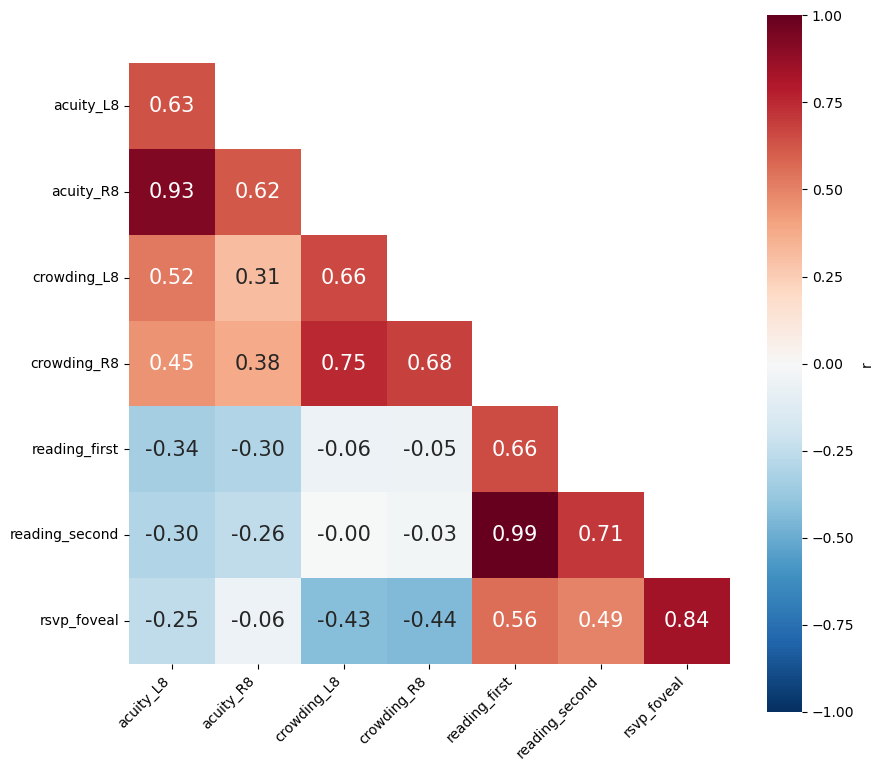

In [90]:
corr_mtx_meridian_r_measured = create_corr_mtx(corr_meridian_df, all_tasks_summary_from_indThresh_meridian_truncated, var_ceiling_pairs_meridian, value_col="r_measured")
plot_mtx_heatmap(corr_mtx_meridian_r_measured, fontSize=15)
corr_mtx_meridian_r_corrected = create_corr_mtx(corr_meridian_df, all_tasks_summary_from_indThresh_meridian_truncated, var_ceiling_pairs_meridian, value_col="r_corrected")
plot_mtx_heatmap(corr_mtx_meridian_r_corrected, fontSize=15)

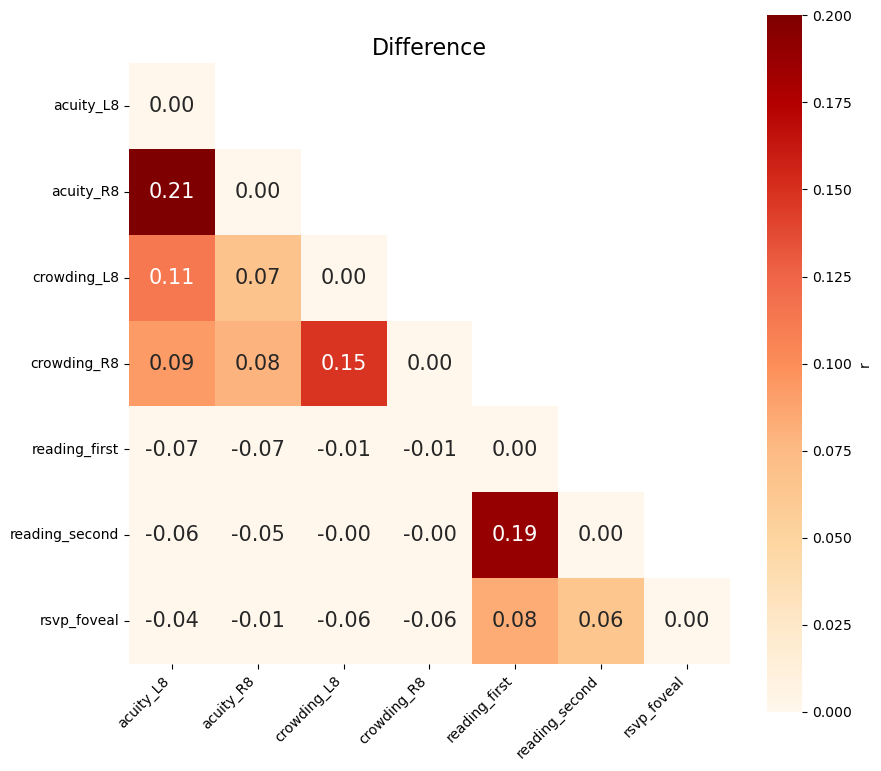

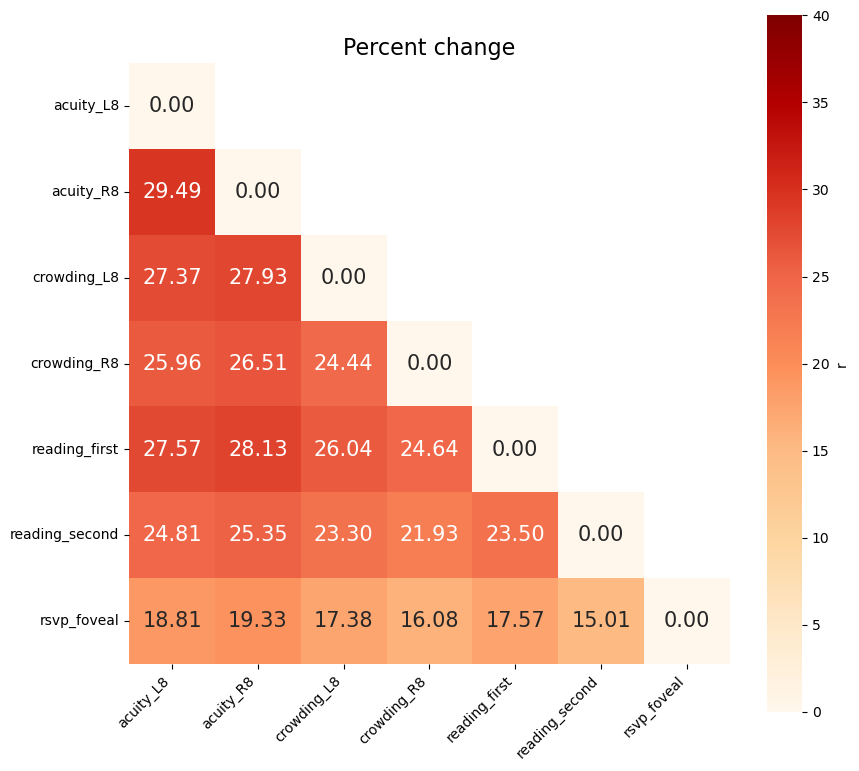

In [91]:
difference_mtx = corr_mtx_meridian_r_corrected - corr_mtx_meridian_r_measured 
plot_mtx_heatmap(difference_mtx, title='Difference', fontSize=15, valmin=0, valmax=0.2, colormap='OrRd')
percentchange_mtx = (corr_mtx_meridian_r_corrected - corr_mtx_meridian_r_measured) / corr_mtx_meridian_r_measured * 100
plot_mtx_heatmap(percentchange_mtx, title='Percent change', fontSize=15, valmin=0, valmax=40, colormap='OrRd')